#### AR(p), MA(q), ARMA(p,q) Model - Predict KOSPI 200 Financial Index
- ##### Author. Choi Sungryeol
- ##### Last Edit. 2022 - 12 - 16

In [1]:
import pandas as pd
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager, rc
import FinanceDataReader as fdr
import seaborn as sns
import time
from datetime import datetime, date
start_time = time.time()
from pandas import DataFrame
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")
from scipy.stats import norm
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import norm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AR
import requests
import json
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import arch
from sklearn.preprocessing import MinMaxScaler
import statsmodels

In [5]:
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [6]:
def acf_plot(data, N_LAGS, alpha):
    from statsmodels.graphics.tsaplots import plot_acf
    fig = plot_acf(data, lags=N_LAGS, alpha=alpha)
    plt.xlabel(f'Lag at 0 to {N_LAGS}')
    plt.ylabel("Lag at k's autocorrelation")
    plt.show()

In [8]:
def to_datetime_format(df:pd.DataFrame, col_nm:str='index', as_index=False) -> pd.DataFrame:
    df[col_nm] = pd.to_datetime(df[col_nm], infer_datetime_format=True) #format = "%Y-%m-%d"
    df = df.sort_values(by=col_nm, ascending=True)
    if as_index:
        df.set_index(col_nm, inplace=True)
    
    return df

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [62]:
from statsmodels.compat.pandas import deprecate_kwarg
from collections.abc import Iterable
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.regression.linear_model import OLS, RegressionResultsWrapper
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tools.validation import (array_like, int_like, bool_like,
                                          string_like, dict_like, float_like)
from statsmodels.stats._lilliefors import (kstest_fit, lilliefors,
                                           kstest_normal, kstest_exponential)
from statsmodels.stats._adnorm import normal_ad, anderson_statistic
__all__ = ["kstest_fit", "lilliefors", "kstest_normal", "kstest_exponential",
           "normal_ad", "compare_cox", "compare_j", "acorr_breusch_godfrey",
           "acorr_ljungbox", "acorr_lm", "het_arch", "het_breuschpagan",
           "het_goldfeldquandt", "het_white", "spec_white", "linear_lm",
           "linear_rainbow", "linear_harvey_collier", "anderson_statistic"]


NESTED_ERROR = """\
The exog in results_x and in results_z are nested. {test} requires \
that models are non-nested.
"""


def _check_nested_exog(small, large):
    """
    Check if a larger exog nests a smaller exog
    """

    if small.shape[1] > large.shape[1]:
        return False
    coef = np.linalg.lstsq(large, small, rcond=None)[0]
    err = small - large @ coef
    return np.linalg.matrix_rank(np.c_[large, err]) == large.shape[1]


def _check_nested_results(results_x, results_z):
    if not isinstance(results_x, RegressionResultsWrapper):
        raise TypeError("results_x must come from a linear regression model")
    if not isinstance(results_z, RegressionResultsWrapper):
        raise TypeError("results_z must come from a linear regression model")
    if not np.allclose(results_x.model.endog, results_z.model.endog):
        raise ValueError("endogenous variables in models are not the same")

    x = results_x.model.exog
    z = results_z.model.exog

    nested = False
    if x.shape[1] <= z.shape[1]:
        nested = nested or _check_nested_exog(x, z)
    else:
        nested = nested or _check_nested_exog(z, x)
    return nested


class ResultsStore:
    def __str__(self):
        return getattr(self, '_str', self.__class__.__name__)

def acorr_lm(resid, nlags=None, store=False, *, period=None,
             ddof=0, cov_type="nonrobust", cov_kwargs=None):
    """
    Lagrange Multiplier tests for autocorrelation.

    This is a generic Lagrange Multiplier test for autocorrelation. Returns
    Engle's ARCH test if resid is the squared residual array. Breusch-Godfrey
    is a variation on this test with additional exogenous variables.
    """
    resid = array_like(resid, "resid", ndim=1)
    cov_type = string_like(cov_type, "cov_type")
    cov_kwargs = {} if cov_kwargs is None else cov_kwargs
    cov_kwargs = dict_like(cov_kwargs, "cov_kwargs")
    nobs = resid.shape[0]
    if period is not None and nlags is None:
        maxlag = min(nobs // 5, 2 * period)
    elif nlags is None:
        maxlag = min(10, nobs // 5)
    else:
        maxlag = nlags

    xdall = lagmat(resid[:, None], maxlag, trim="both")
    nobs = xdall.shape[0]
    xdall = np.c_[np.ones((nobs, 1)), xdall]
    xshort = resid[-nobs:]
    res_store = ResultsStore()
    usedlag = maxlag

    resols = OLS(xshort, xdall[:, :usedlag + 1]).fit(cov_type=cov_type,
                                                     cov_kwargs=cov_kwargs)
    fval = float(resols.fvalue)
    fpval = float(resols.f_pvalue)
    if cov_type == "nonrobust":
        lm = (nobs - ddof) * resols.rsquared
        lmpval = stats.chi2.sf(lm, usedlag)
        # Note: deg of freedom for LM test: nvars - constant = lags used
    else:
        r_matrix = np.hstack((np.zeros((usedlag, 1)), np.eye(usedlag)))
        test_stat = resols.wald_test(r_matrix, use_f=False, scalar=True)
        lm = float(test_stat.statistic)
        lmpval = float(test_stat.pvalue)

    if store:
        res_store.resols = resols
        res_store.usedlag = usedlag
        return lm, lmpval, fval, fpval, res_store
    else:
        return lm, lmpval, fval, fpval
def het_arch(resid, nlags=None, store=False, ddof=0):
    """
    Engle's Test for Autoregressive Conditional Heteroscedasticity (ARCH).
    """
    return acorr_lm(resid ** 2, nlags=nlags, store=store, ddof=ddof)

In [12]:
def embed(z, lags):
    res = []
    for i in range(lags):
        temp_z = np.expand_dims(z[lags-1-i:len(z)-i], axis=1)
        res.append(temp_z)
    res = np.concatenate(res, axis=1)
    return res
 
def get_f_stat(reduced_model, full_model):
    df_num = reduced_model.df_resid - full_model.df_resid
    df_denom = full_model.df_resid
    numerator = reduced_model.mse_resid*reduced_model.df_resid - full_model.mse_resid*full_model.df_resid
    denominator = full_model.mse_resid*full_model.df_resid
    f_stat = (numerator/df_num)/(denominator/df_denom)
    return f_stat
 
def augmented_df_test(y, lags, test_type=None, selectlags=None):
    '''인자 검사'''
    if test_type:
        assert test_type in ('drift', 'trend'), 'test_type must be the one of (None, drift, trend)'
    if selectlags:
        assert selectlags in ('AIC', 'BIC'), 'test_type must be the one of (None, AIC, BIC)'
    lags += 1
    z = np.diff(y)
    n = len(z)
    x = embed(z, lags)
    z_diff = x[:,0]
    z_lag_1 = y[lags-1:n]
    tt = list(range(lags, n+1))
    '''
    1. lags가 1보다 큰 경우 selectlags가 None이 아니면 AIC 또는 BIC 기준에 따라 
    차수 p를 구한다. 
    2. test_type 별로 검정을 수행한다.
    '''
    if lags > 1:
        if selectlags:
            crit_res = []
            for i in range(2, lags+1):
                z_diff_lag = x[:, 1:i]
                if test_type is None:
                    X = np.concatenate([np.expand_dims(z_lag_1,axis=1), z_diff_lag], axis=1)
                    model = sm.OLS(z_diff, X).fit()
                elif test_type == 'drift':
                    X = np.concatenate([np.expand_dims(z_lag_1,axis=1), z_diff_lag], axis=1)
                    X = sm.add_constant(X)
                    model = sm.OLS(z_diff, X).fit()
                else:
                    X = np.concatenate([np.expand_dims(z_lag_1,axis=1), np.expand_dims(tt, axis=1)], axis=1)
                    X = np.concatenate([X, z_diff_lag], axis=1)
                    X = sm.add_constant(X)
                    model = sm.OLS(z_diff, X).fit()
 
                if selectlags == 'AIC':
                    crit_res.append(model.aic)
                else:
                    crit_res.append(model.bic)
            lags = 2+np.argmin(crit_res)
        z_diff_lag = x[:, 1:lags]
        if test_type is None:
            X = np.concatenate([np.expand_dims(z_lag_1,axis=1), z_diff_lag], axis=1)
            model = sm.OLS(z_diff, X).fit()
            tau = model.tvalues[0]
            test_stat = {'tau1':tau}
        elif test_type == 'drift':
            X = np.concatenate([np.expand_dims(z_lag_1,axis=1), z_diff_lag], axis=1)
            X = sm.add_constant(X)
            model = sm.OLS(z_diff, X).fit()
            tau = model.tvalues[1]
            model_phi = sm.OLS(z_diff, z_diff_lag).fit()
 
            phi1 = get_f_stat(model_phi, model)
            test_stat = {'tau2':tau, 'phi1':phi1}
        else:
            X = np.concatenate([np.expand_dims(z_lag_1,axis=1), np.expand_dims(tt, axis=1)], axis=1)
            X = np.concatenate([X, z_diff_lag], axis=1)
            X = sm.add_constant(X)
            model = sm.OLS(z_diff, X).fit()
            tau = model.tvalues[1]
            model_phi2 = sm.OLS(z_diff, z_diff_lag).fit()
            X_temp = sm.add_constant(z_diff_lag)
            model_phi3 = sm.OLS(z_diff, X_temp).fit()
            phi2 = get_f_stat(model_phi2, model)
            phi3 = get_f_stat(model_phi3, model)
            test_stat = {'tau3':tau, 'phi2':phi2, 'phi3':phi3}
    else:
        if test_type is None:
            model = sm.OLS(z_diff, np.expand_dims(z_lag_1,axis=1)).fit()
            tau = model.tvalues[0]
            test_stat = {'tau1':tau}
        elif test_type == 'drift':
            X = np.expand_dims(z_lag_1,axis=1)
            X = sm.add_constant(X)
            model = sm.OLS(z_diff, X).fit()
            tau = model.tvalues[1]
            rss_null = np.sum(np.square(z_diff))
            df_num = len(z_diff) - model.df_resid
            df_denom = model.df_resid
            numorator = rss_null - model.mse_resid*model.df_resid
            denominator = model.mse_resid*model.df_resid
            phi1 = (numorator/df_num)/(denominator/df_denom)
            test_stat = {'tau2':tau, 'phi1':phi1}
        else:
            X = np.concatenate([np.expand_dims(z_lag_1,axis=1), np.expand_dims(tt, axis=1)], axis=1)
            X = sm.add_constant(X)
            model = sm.OLS(z_diff, X).fit()
            tau = model.tvalues[1]
 
            rss_null = np.sum(np.square(z_diff))
            df_num = len(z_diff) - model.df_resid
            df_denom = model.df_resid
            numorator = rss_null - model.mse_resid*model.df_resid
            denominator = model.mse_resid*model.df_resid
            phi2 = (numorator/df_num)/(denominator/df_denom)
            model_phi3 = sm.OLS(z_diff, [1]*len(z_diff)).fit()
            phi3 = get_f_stat(model_phi3, model)
            test_stat = {'tau3':tau, 'phi2':phi2, 'phi3':phi3}
 
#     res = model.resid
    '''샘플 사이즈에 맞는 테이블을 가져온다.'''
    if n < 25:
        rowselec = 0
    elif n < 50:
        rowselec = 1
    elif n < 100:
        rowselec = 2
    elif n < 250:
        rowselec = 3
    elif n < 500:
        rowselec = 4
    else:
        rowselec = 5
 
    if test_type is None:
        cval_tau1 = np.array([(-2.66, -1.95, -1.6),(-2.62, -1.95, -1.61),(-2.6, -1.95, -1.61),
             (-2.58, -1.95, -1.62),(-2.58, -1.95, -1.62),(-2.58, -1.95, -1.62)])
        cval = cval_tau1[rowselec, :]
        cval = np.expand_dims(cval, axis=0)
        test_name = ['tau1']
    elif test_type == 'drift':
        cval_tau2 = np.array([(-3.75, -3, -2.63),(-3.58, -2.93, -2.6),(-3.51, -2.89, -2.58),
                         (-3.46, -2.88, -2.57),(-3.44, -2.87, -2.57),(-3.43, -2.86, -2.57)])
        cval_phi1 = np.array([(7.88, 5.18, 4.12),(7.06, 4.86, 3.94),(6.7, 4.71, 3.86),
                          (6.52, 4.63, 3.81),(6.47, 4.61, 3.79),(6.43, 4.59, 3.78)])
        cval = np.array([cval_tau2[rowselec, :],cval_phi1[rowselec, :]])
        test_name = ['tau2', 'phi1']
    else:
        cval_tau3 = np.array([(-4.38, -3.6, -3.24),(-4.15, -3.5, -3.18),(-4.04, -3.45, -3.15),
                         (-3.99, -3.43, -3.13),(-3.98, -3.42, -3.13),(-3.96, -3.41,-3.12)])
        cval_phi2 = np.array([(8.21, 5.68, 4.67), (7.02, 5.13, 4.31),(6.5, 4.88, 4.16),
                             (6.22, 4.75, 4.07),(6.15, 4.71, 4.05),(6.09, 4.68, 4.03)])
        cval_phi3 = np.array([(10.61, 7.24, 5.91),(9.31, 6.73, 5.61),(8.73, 6.49, 5.47),
                              (8.43, 6.49, 5.47),(8.34, 6.3, 5.36),(8.27, 6.25, 5.34)])
        cval = np.array([cval_tau3[rowselec, :], cval_phi2[rowselec, :], cval_phi3[rowselec, :]])
        test_name = ['tau3', 'phi2', 'phi3']
 
    results = pd.DataFrame(cval)
    results.columns = ('1pct', '5pct', '10pct')
    results.insert(0, 'TEST_NAME', test_name)
    results.insert(1, 'TEST_STAT', [test_stat[x] for x in test_name])
 
    return (results, lags-1)

In [13]:
def acf(series, k):
    mean = series.mean()
    denominator = np.sum(np.square(series-mean))
    numerator = np.sum((series-mean)*(series.shift(k)-mean))
    acf_val = numerator/denominator
    return acf_val
 
def pacf(series, k):
    if k == 0:
        pacf_val = 1
    else:
        gamma_array = np.array([acf(series, k) for k in range(1,k+1)])
 
        gamma_matrix = []
        for i in range(k):
            temp = [0]*k
            temp[i:] = [acf(series, j) for j in range(k-i)]
            gamma_matrix.append(temp)
 
        gamma_matrix = np.array(gamma_matrix)
        gamma_matrix = gamma_matrix + gamma_matrix.T - np.diag(gamma_matrix.diagonal())
        pacf_val = np.linalg.inv(gamma_matrix).dot(gamma_array)[-1]
    return pacf_val

In [37]:
csv_list = list(filter(lambda x : x.split('.')[-1] == 'csv', os.listdir()))
print(csv_list)
df = pd.DataFrame()
for file in csv_list:
    tmp_df = pd.read_csv(file, thousands = ',')
    df = pd.DataFrame(tmp_df.iloc[:,[0,1]])
    df.columns = ["date", "close"]
    print(df)
df["date"] = pd.to_datetime(df["date"])
print(df.dtypes)

['KOSPI_200_Real.csv']
           date   close
0    2000-02-01  103.17
1    2000-03-01  108.03
2    2000-04-01   91.21
3    2000-05-01   92.74
4    2000-06-01  104.43
..          ...     ...
270  2022-08-01  322.96
271  2022-09-01  281.36
272  2022-10-01  299.58
273  2022-11-01  321.00
274  2022-12-01  306.77

[275 rows x 2 columns]
date     datetime64[ns]
close           float64
dtype: object


In [39]:
y = df["close"]
y

0      103.17
1      108.03
2       91.21
3       92.74
4      104.43
        ...  
270    322.96
271    281.36
272    299.58
273    321.00
274    306.77
Name: close, Length: 275, dtype: float64

In [16]:
pd.DataFrame(df["close"].describe(include='all'))

,close
count,275.000000
mean,219.831855
std,88.876861
min,58.910000
25%,144.835000
50%,243.630000
75%,269.870000
max,438.840000


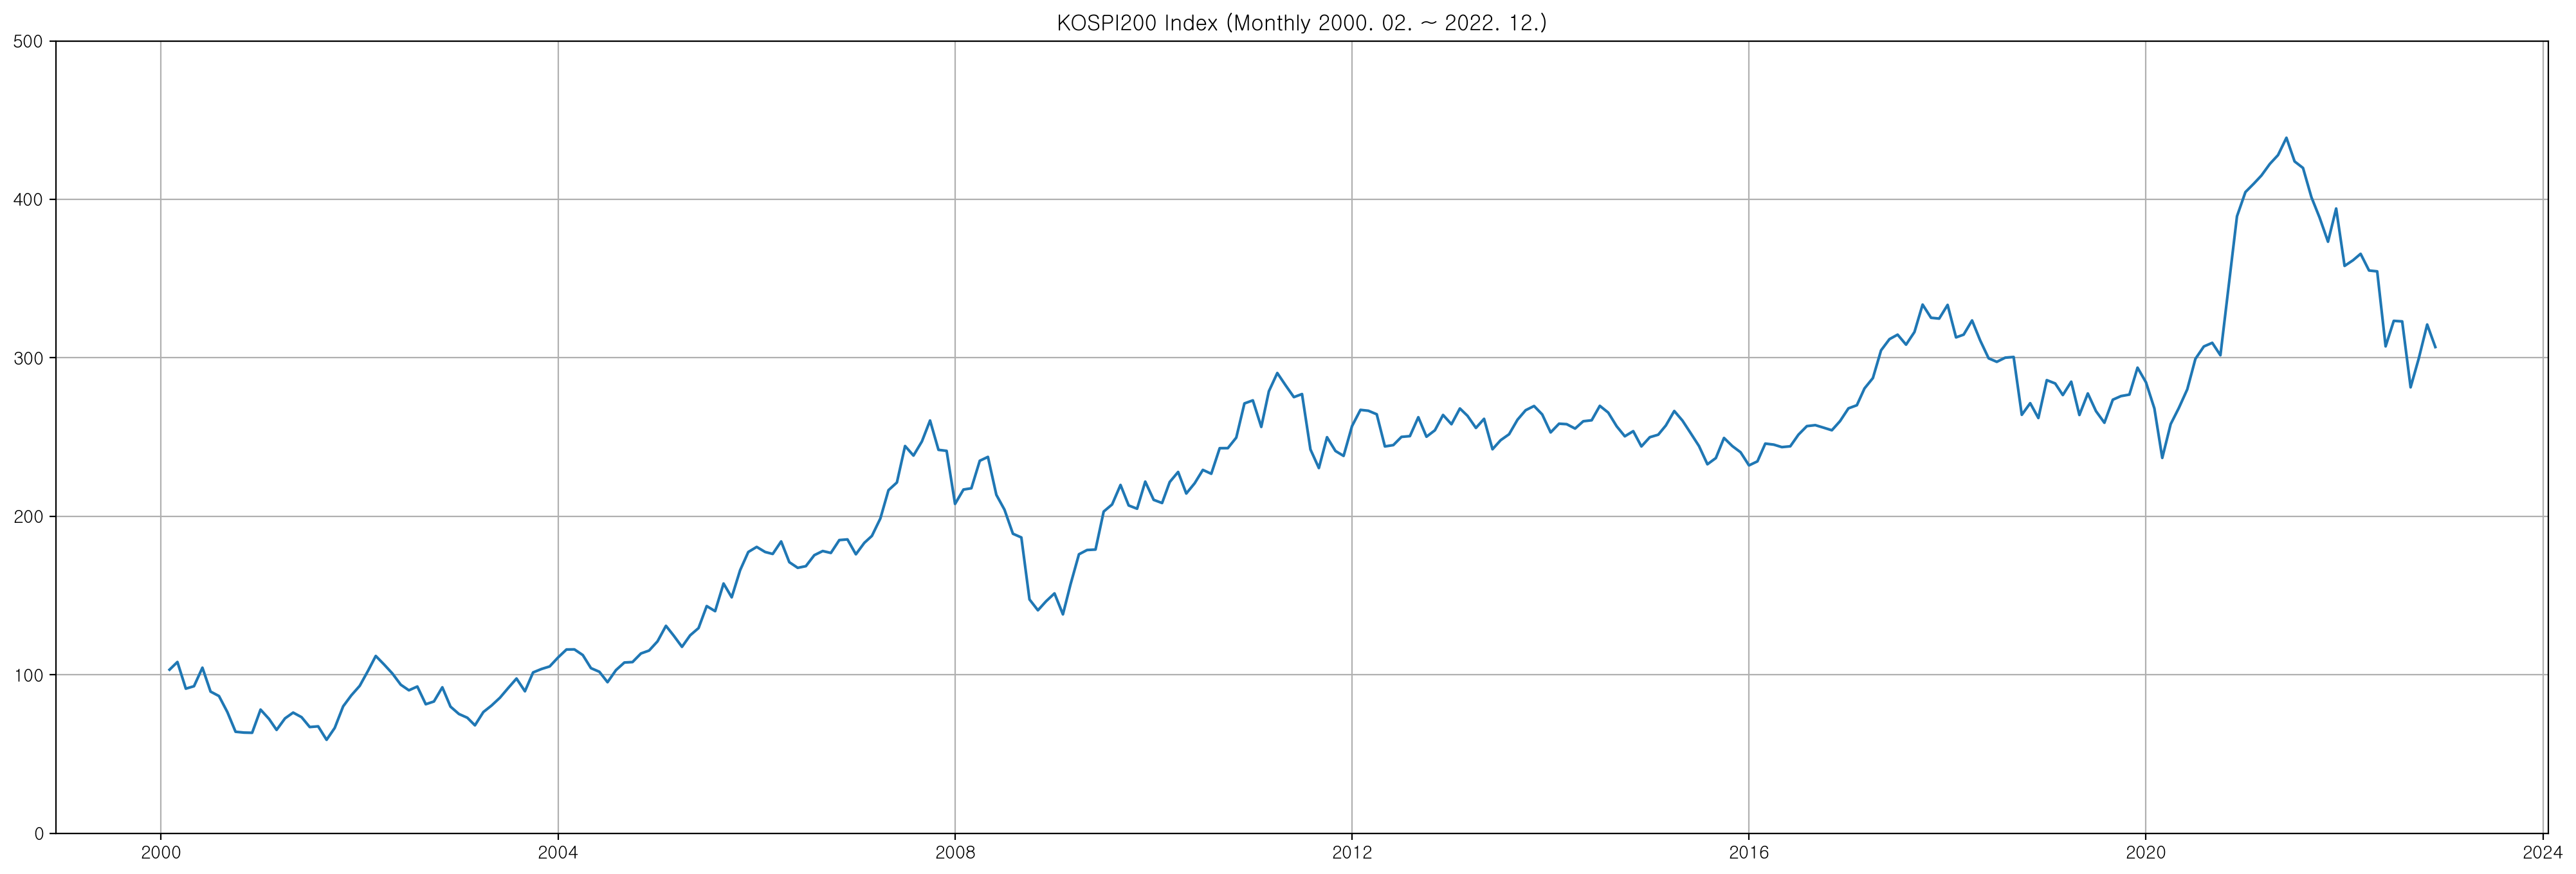

In [17]:
plt.figure(figsize=(25,8))
plt.ylim([0,500])
plt.plot(df["date"], df["close"], linewidth = 1.5)
plt.title("KOSPI200 Index (Monthly 2000. 02. ~ 2022. 12.)")
plt.grid(True)
plt.show()

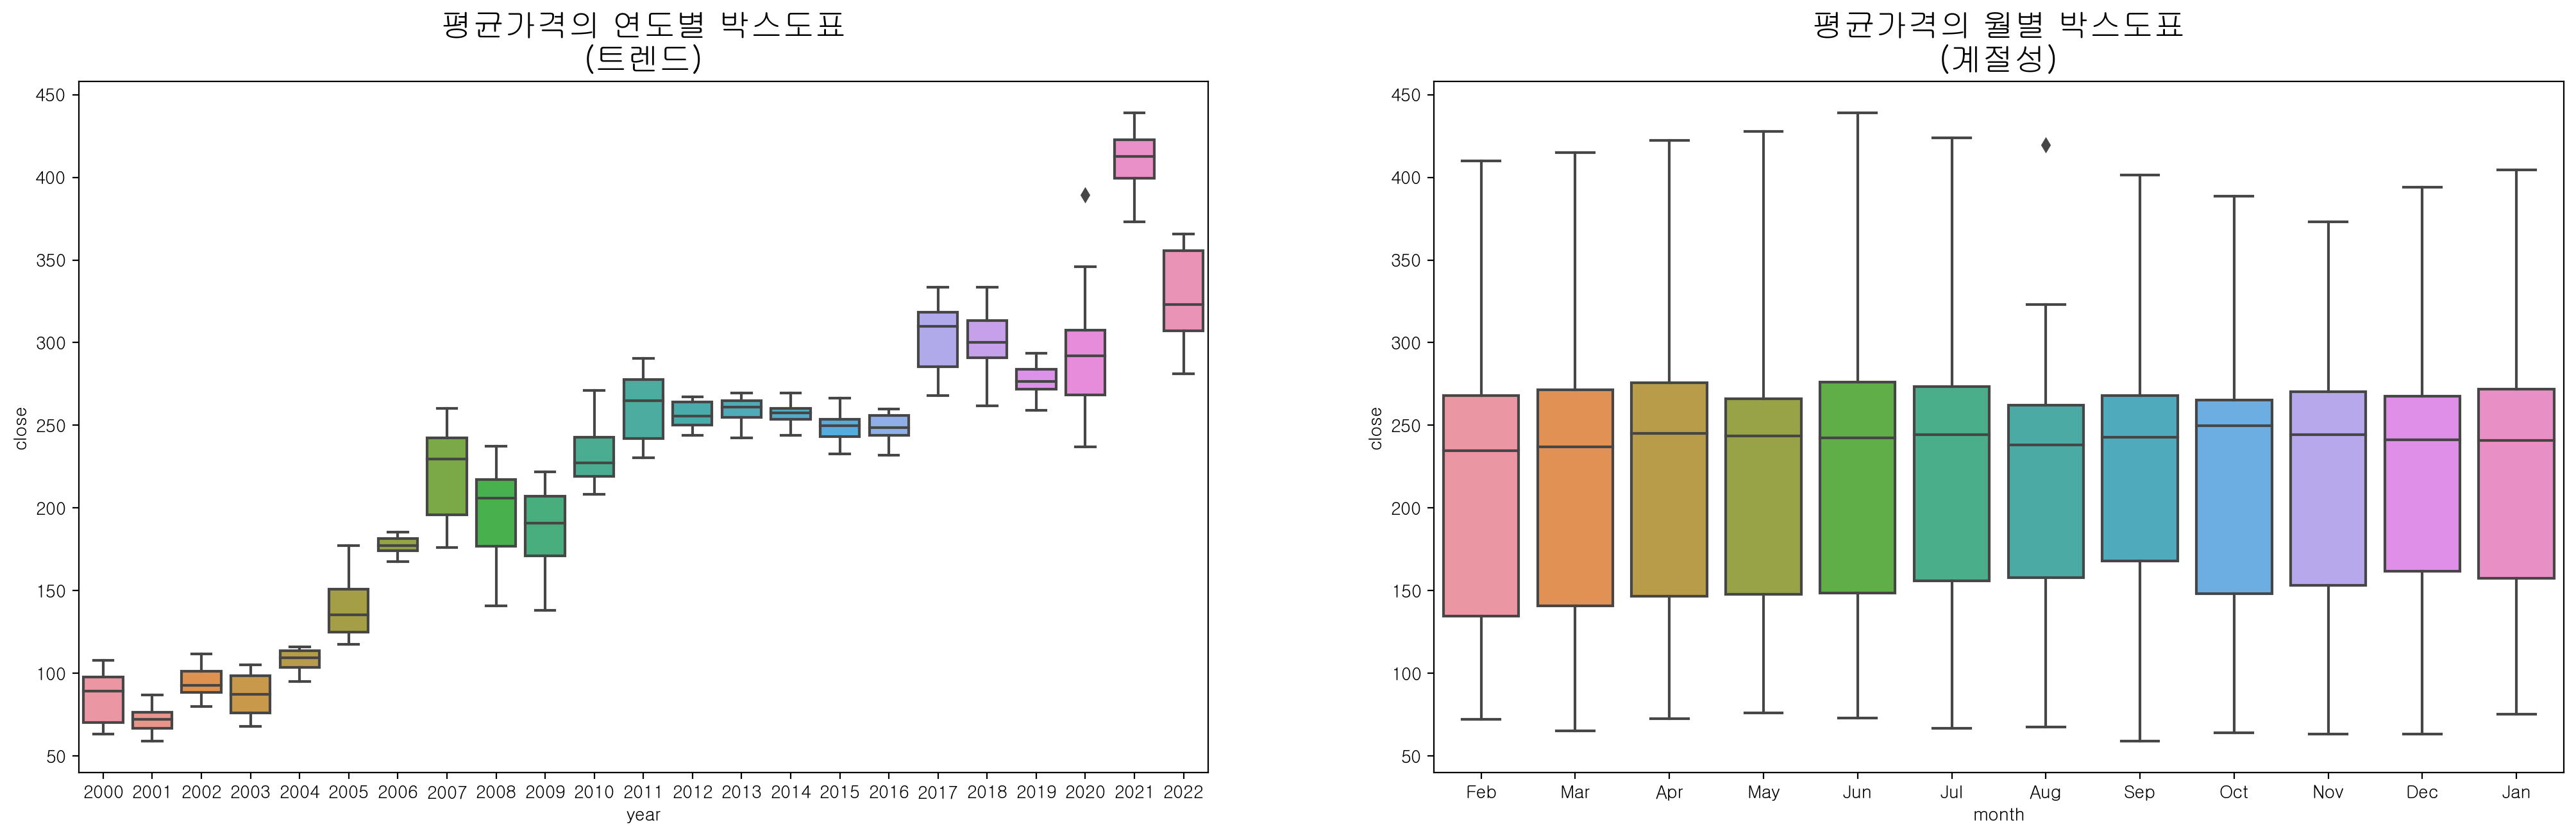

In [18]:
df["year"] = [d.year for d in df.date]
df["month"] = [d.strftime('%b') for d in df.date]
years = df["year"].unique()
np.random.seed(153)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace = False)
fig, axes = plt.subplots(1, 2, figsize=(25,7), dpi= 100)
sns.boxplot(x='year', y=df.iloc[:,1], data=df, ax=axes[0])
sns.boxplot(x='month', y=df.iloc[:,1], data=df, ax=axes[1])
axes[0].set_title('평균가격의 연도별 박스도표\n(트렌드)', fontsize=18)
axes[1].set_title('평균가격의 월별 박스도표\n(계절성)', fontsize=18)
plt.show()

<Figure size 640x480 with 0 Axes>

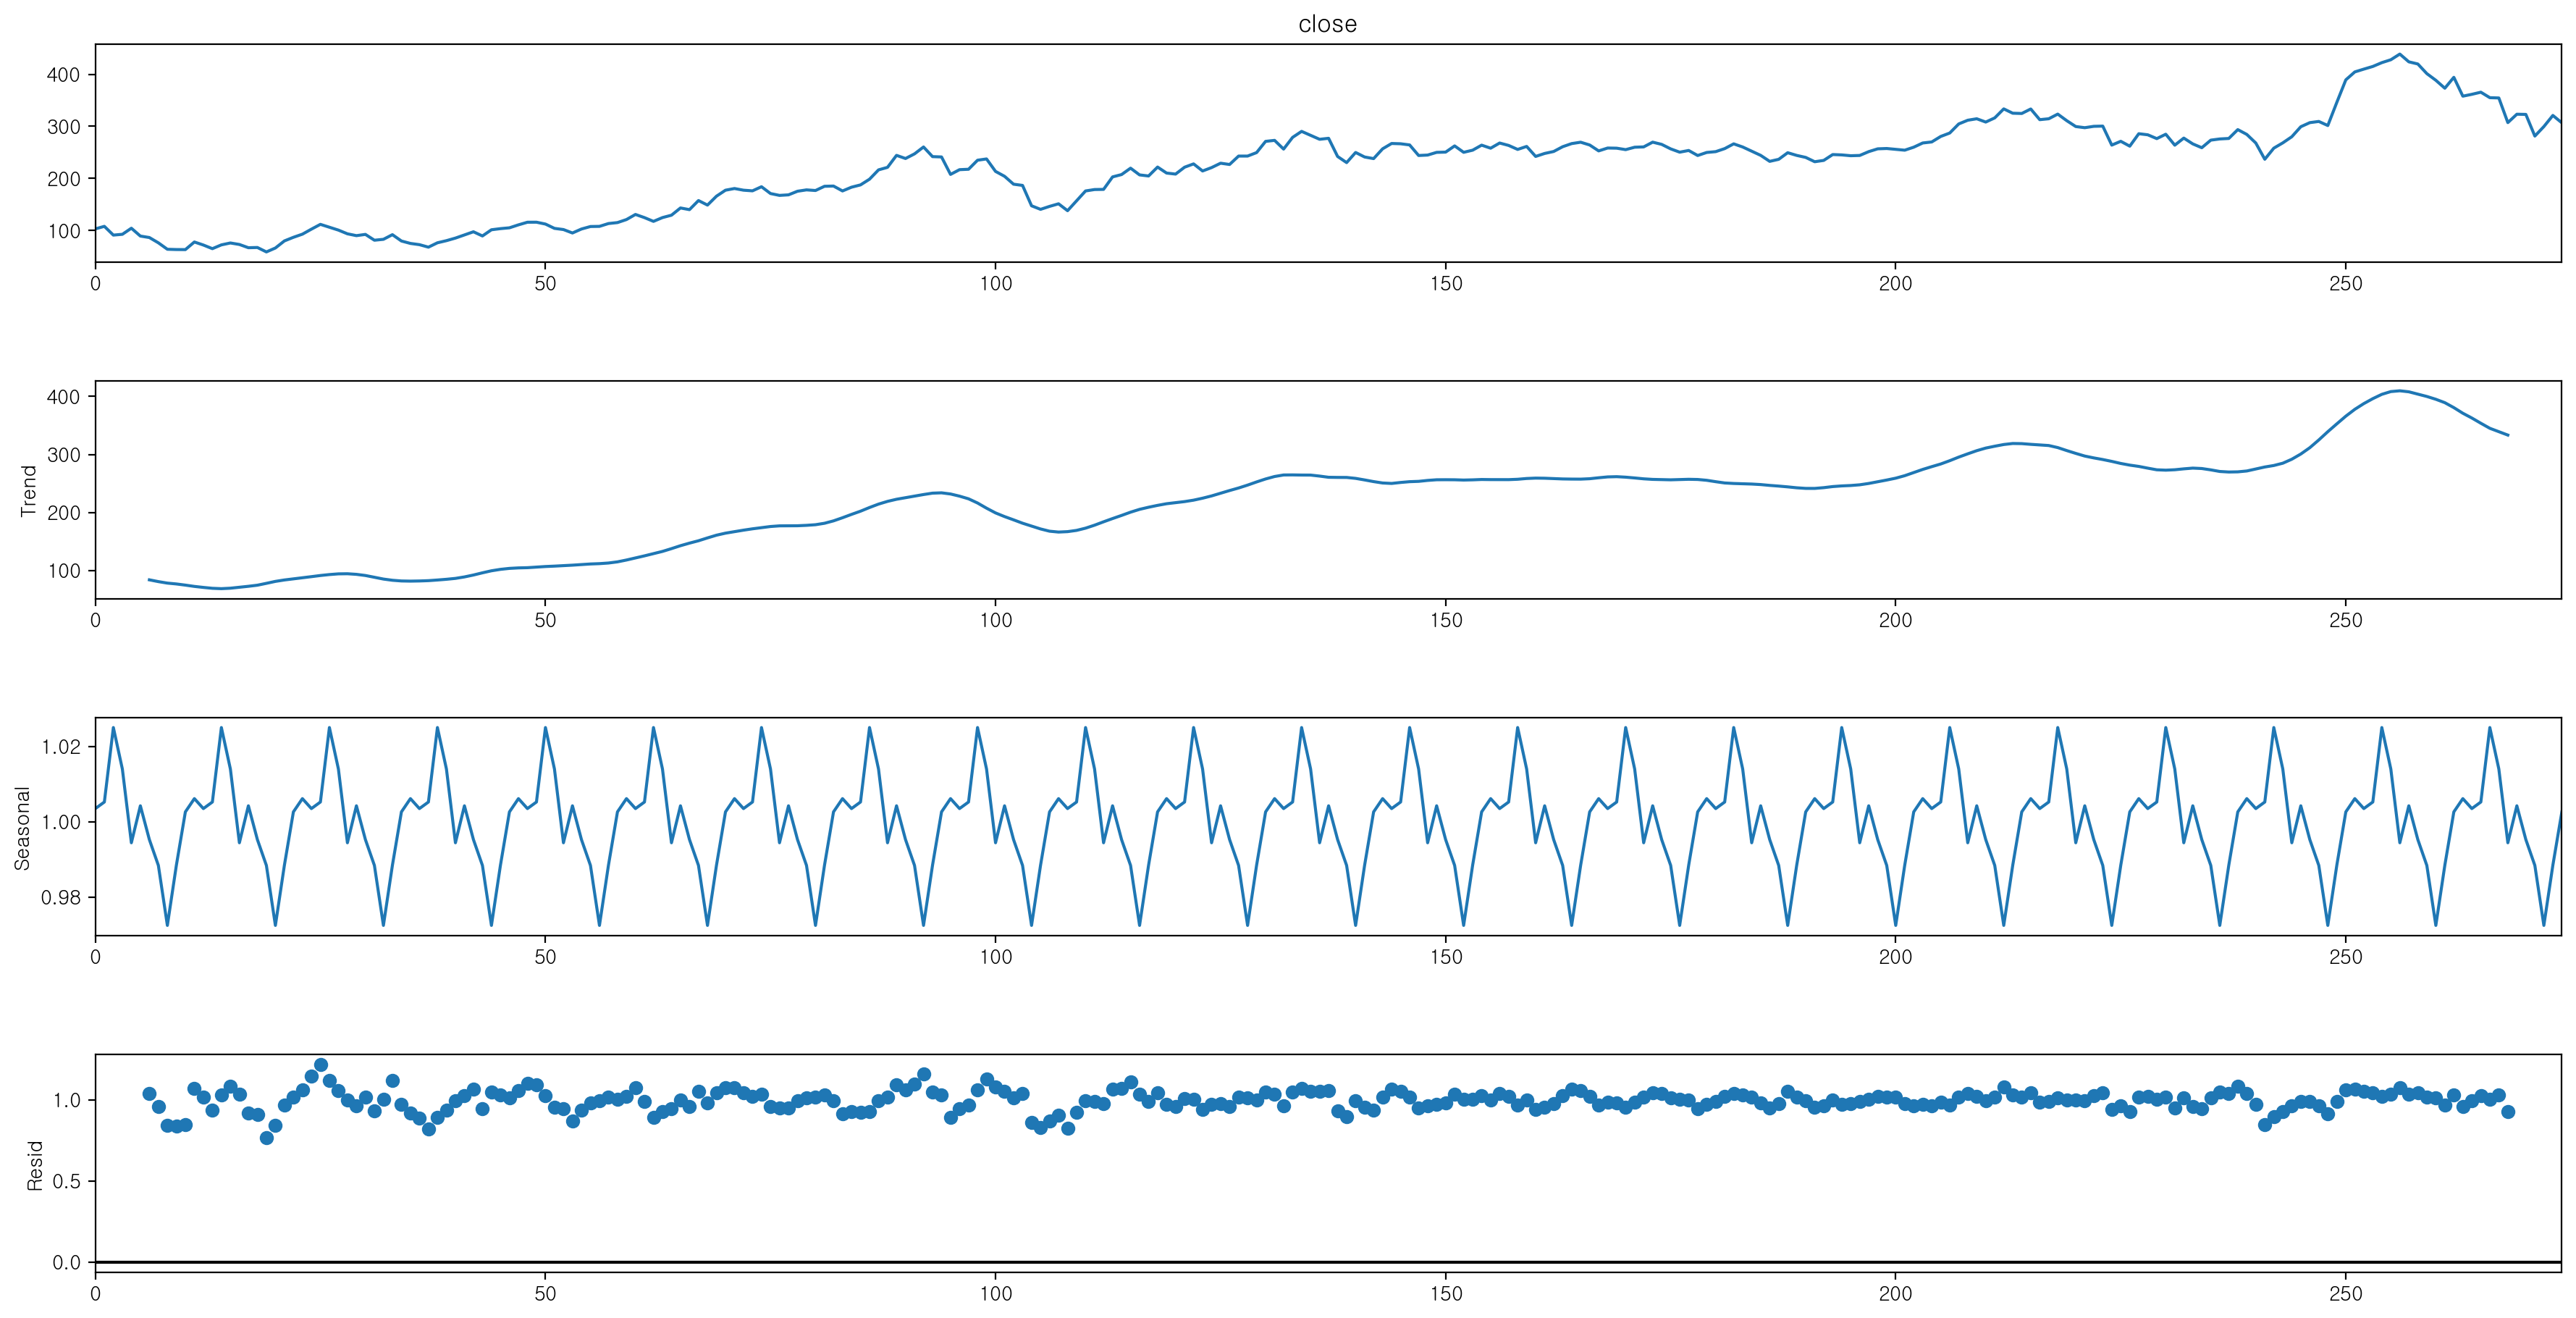

In [19]:
revenued = df.loc[:,"close"]
result = seasonal_decompose(revenued, model='multiplicative', period=12)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,10)

In [20]:
print('ADF TEST: KOSPI 200 Index time series')
print('Null hypothesis: Time Series are Not Stationary ')
print('Alternative hypothesis: Time Series are Stationary (When p-value < 0.05) ')
adf_test(df['close'])

ADF TEST: KOSPI 200 Index time series
Null hypothesis: Time Series are Not Stationary 
Alternative hypothesis: Time Series are Stationary (When p-value < 0.05) 
ADF Statistics: -1.552450
p-value: 0.507424
Critical values:
	1%: -3.455
	5%: -2.872
	10%: -2.572


## Seasonal Adjustment

In [34]:
log_diff = df
log_diff.iloc[:,1] = np.log(log_diff.iloc[:,1])
log_diff.iloc[:,1] = log_diff.iloc[:,1].diff(1)
log_diff = log_diff.iloc[1:,]

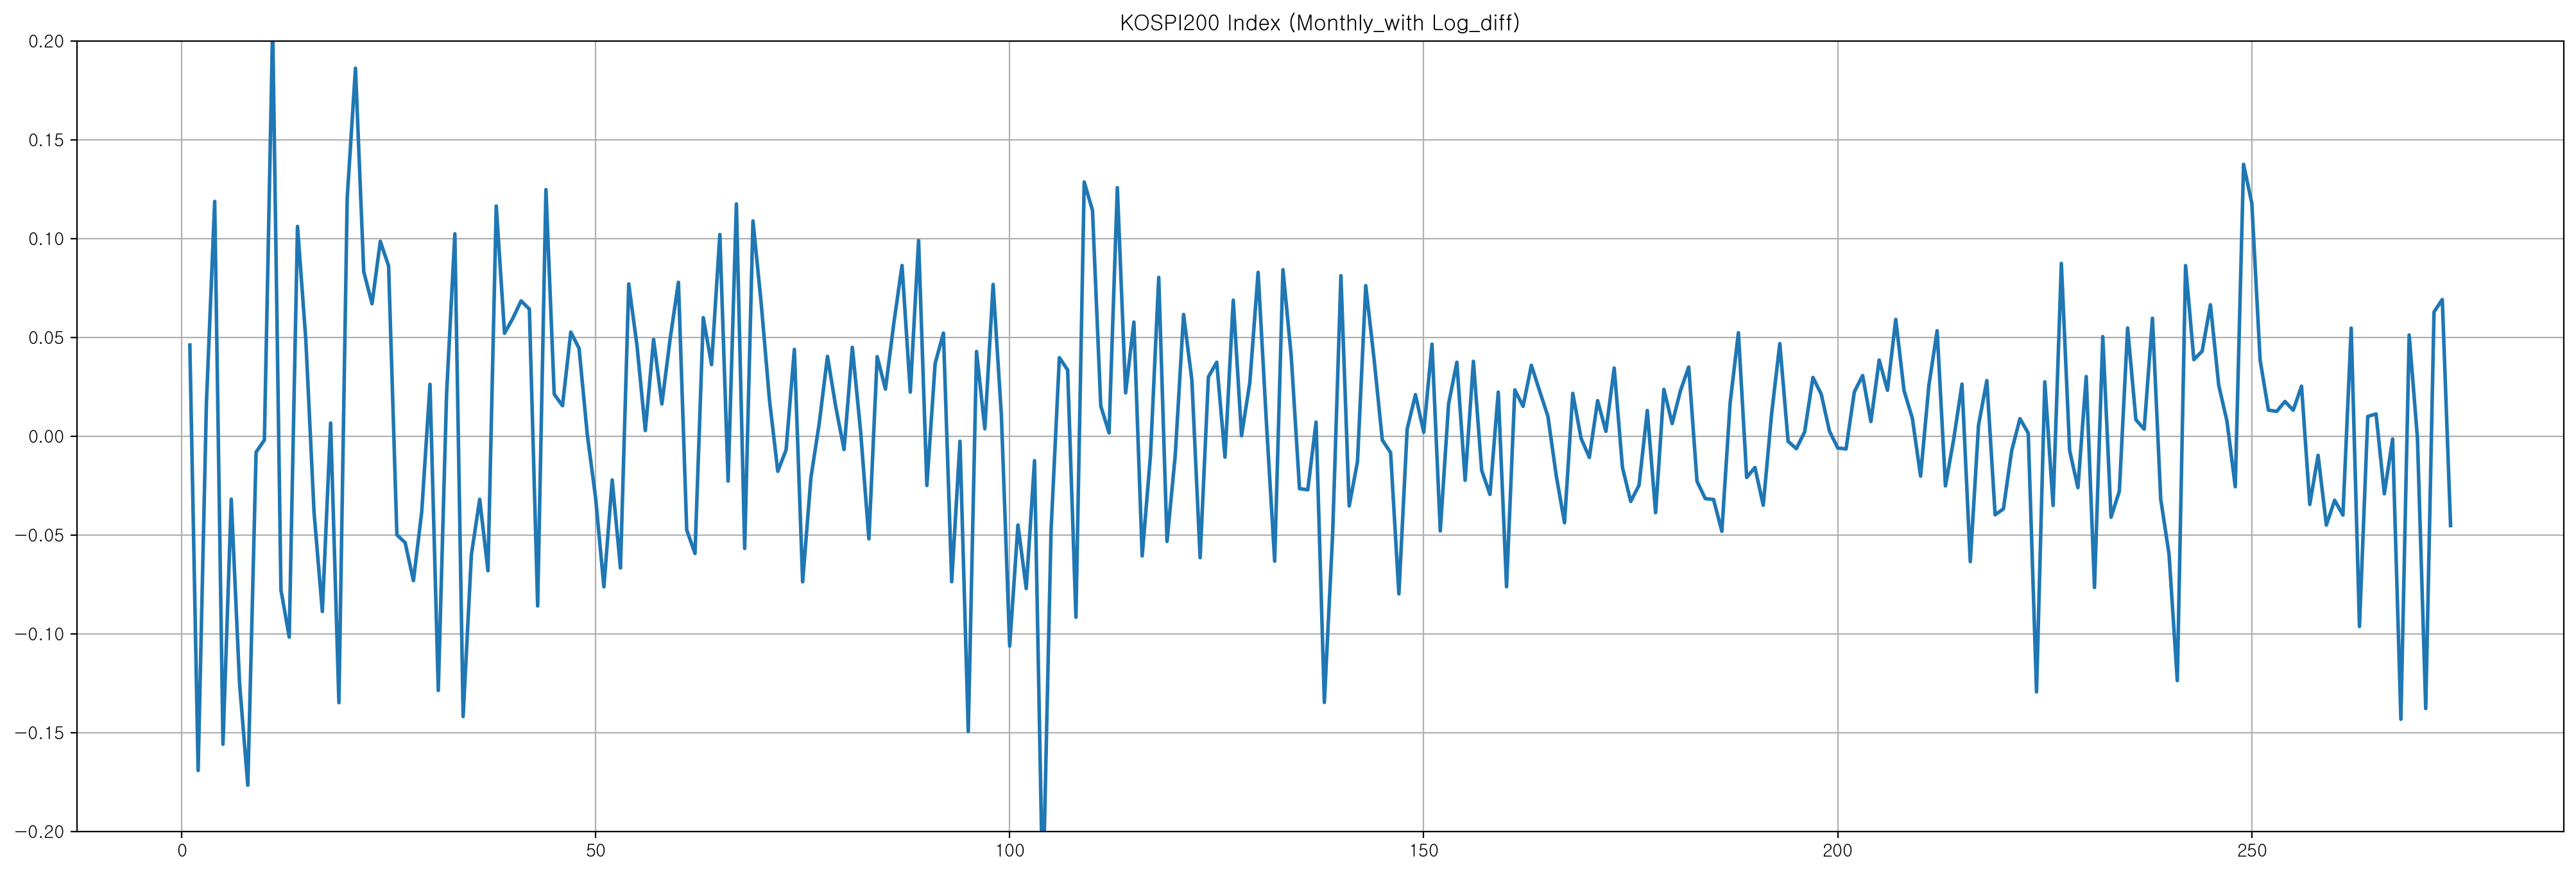

In [22]:
plt.figure(figsize=(25,8))
plt.ylim([-0.2,0.2])
plt.plot(log_diff["close"], linewidth = 2)
plt.title("KOSPI200 Index (Monthly_with Log_diff)")
plt.grid(True)
plt.show()

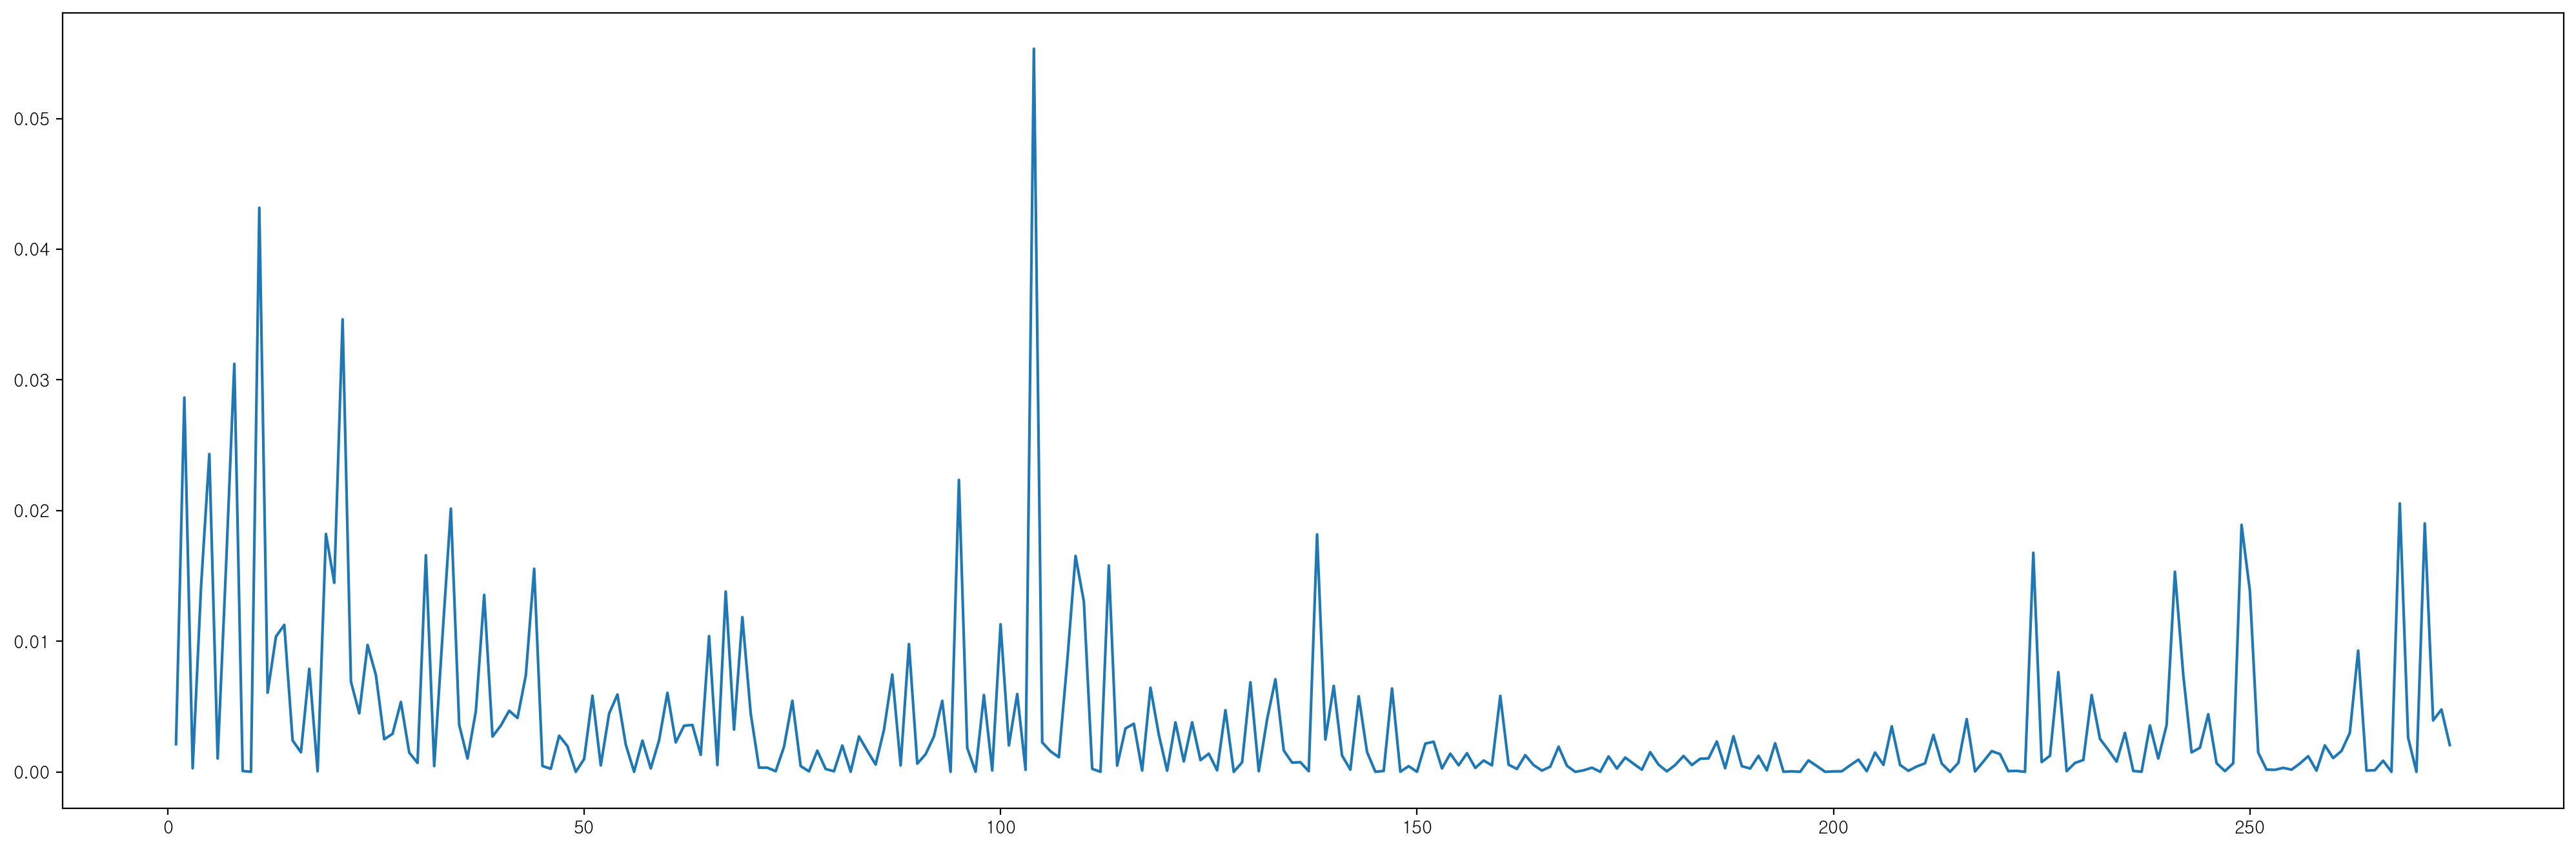

In [23]:
plt.figure(figsize=(25,8))
plt.plot(log_diff["close"]**2)

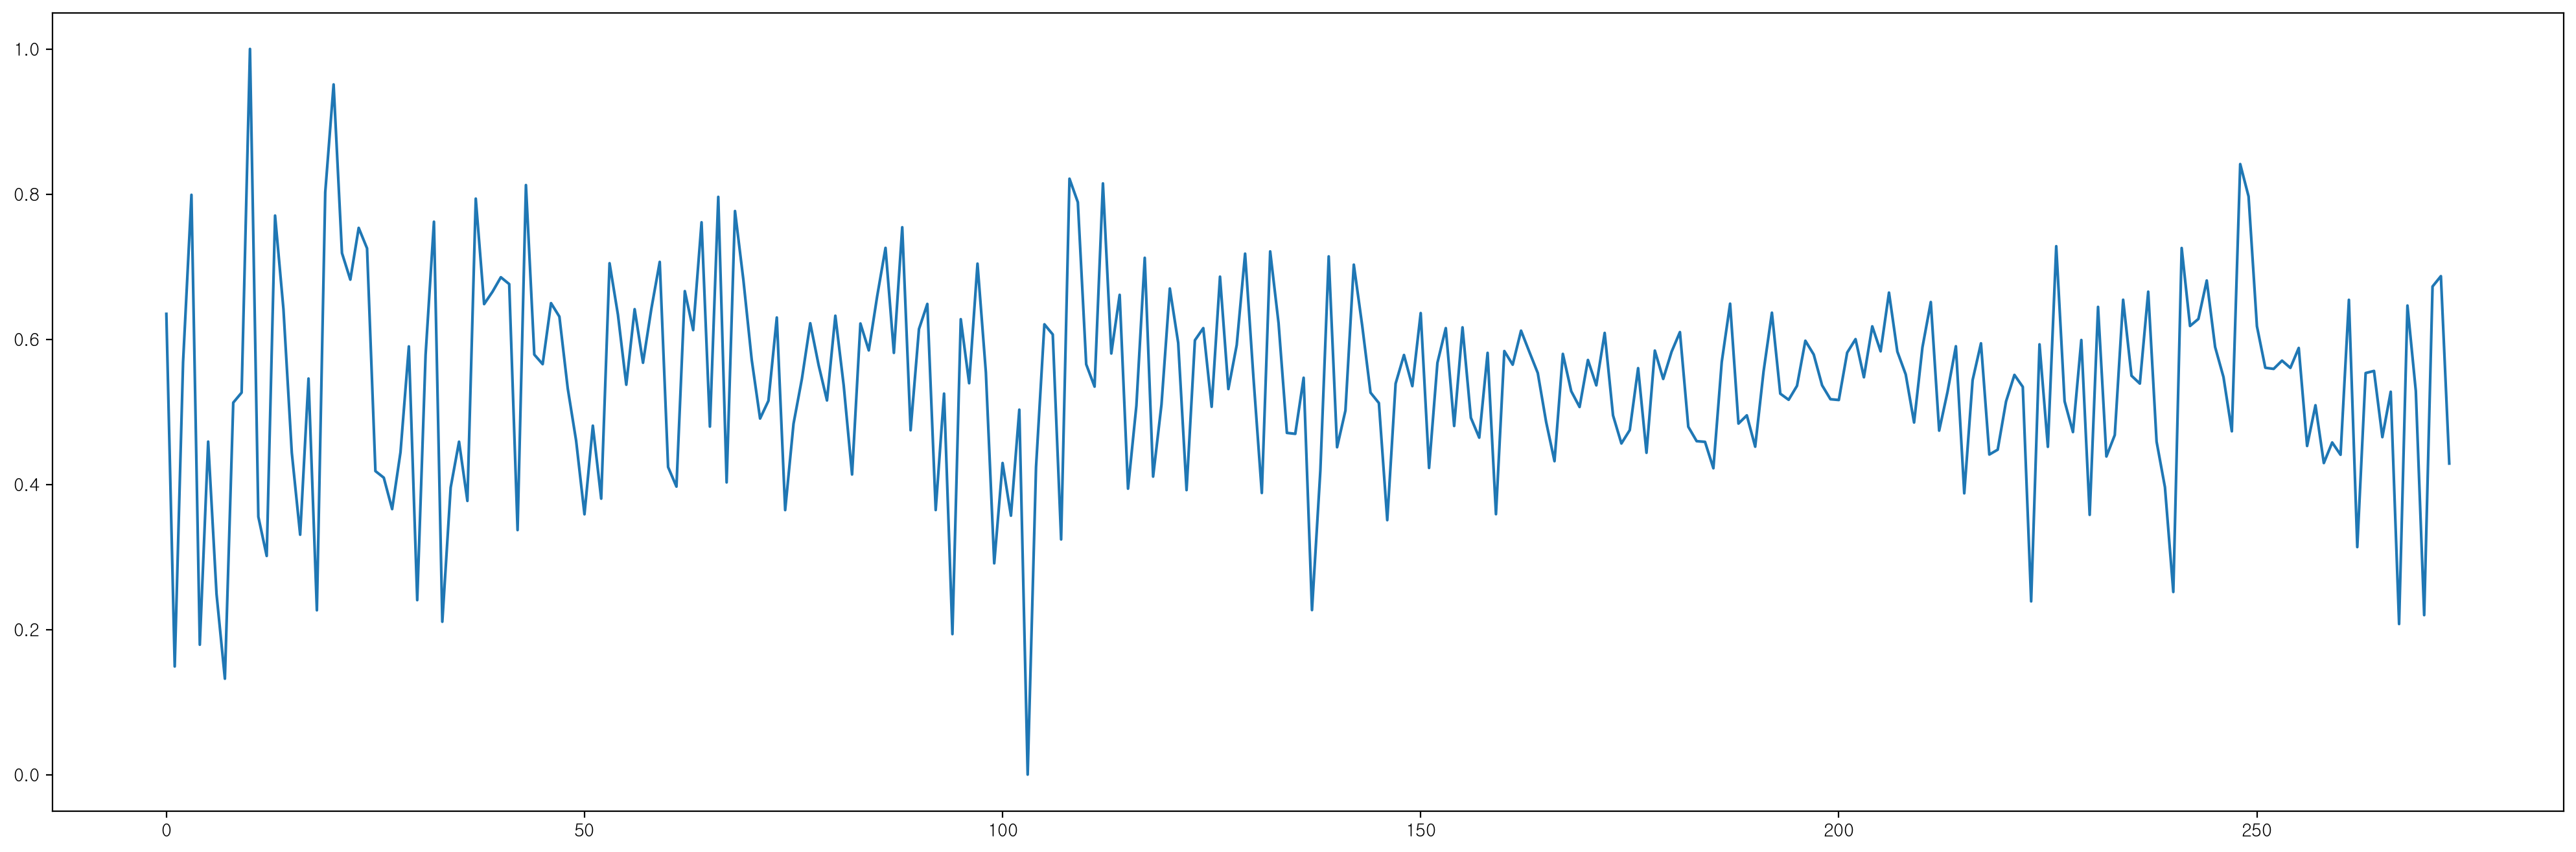

In [24]:
scaler2 = MinMaxScaler()
scale_df_MMax = scaler2.fit_transform(log_diff[["close"]])
plt.figure(figsize=(25,8))
plt.plot(scale_df_MMax)

In [25]:
print('ADF TEST: KOSPI 200 Index(Log - Diff) time series')
print('Null hypothesis: Time Series are Not Stationary ')
print('Alternative hypothesis: Time Series are Stationary (When p-value < 0.05) ')
adf_test(log_diff['close'])

ADF TEST: KOSPI 200 Index(Log - Diff) time series
Null hypothesis: Time Series are Not Stationary 
Alternative hypothesis: Time Series are Stationary (When p-value < 0.05) 
ADF Statistics: -8.261913
p-value: 0.000000
Critical values:
	1%: -3.455
	5%: -2.872
	10%: -2.572


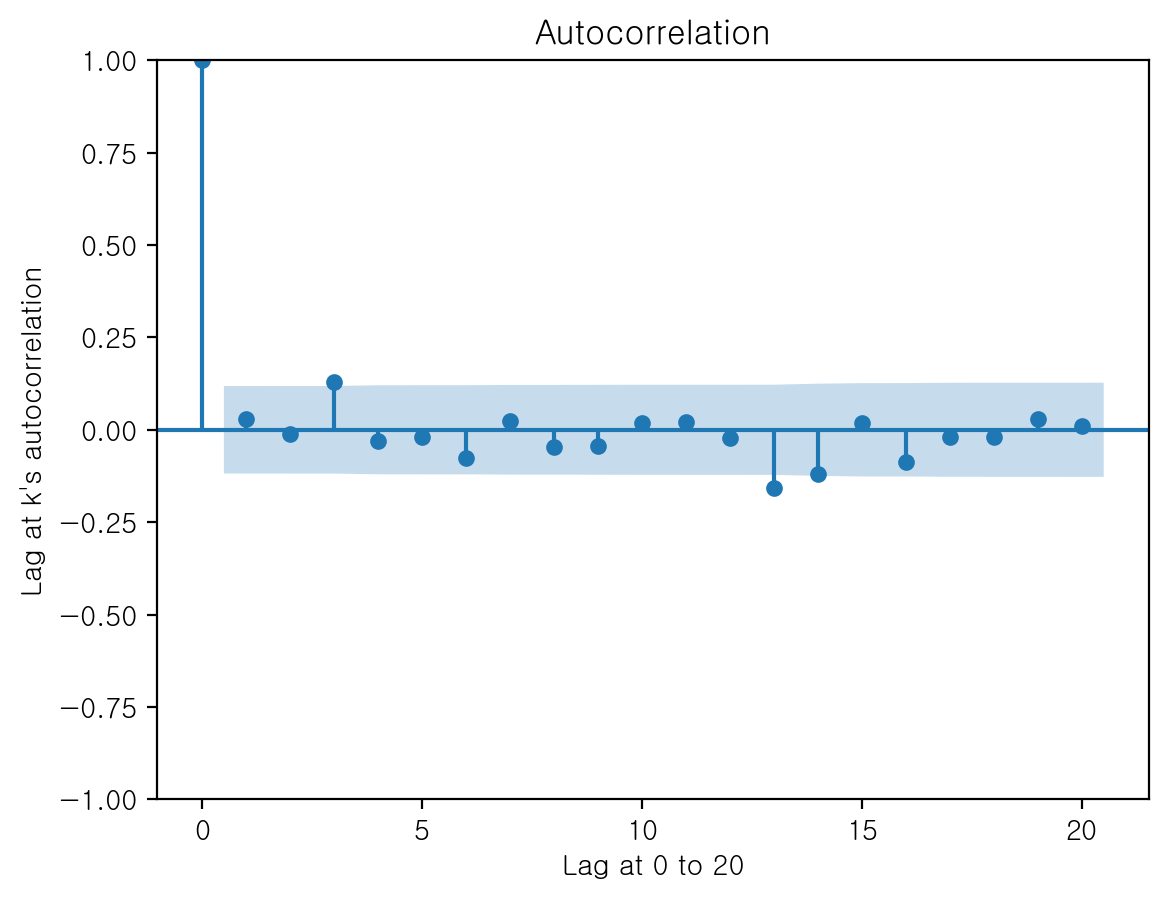

In [26]:
acf_plot(log_diff["close"], 20, 0.05)

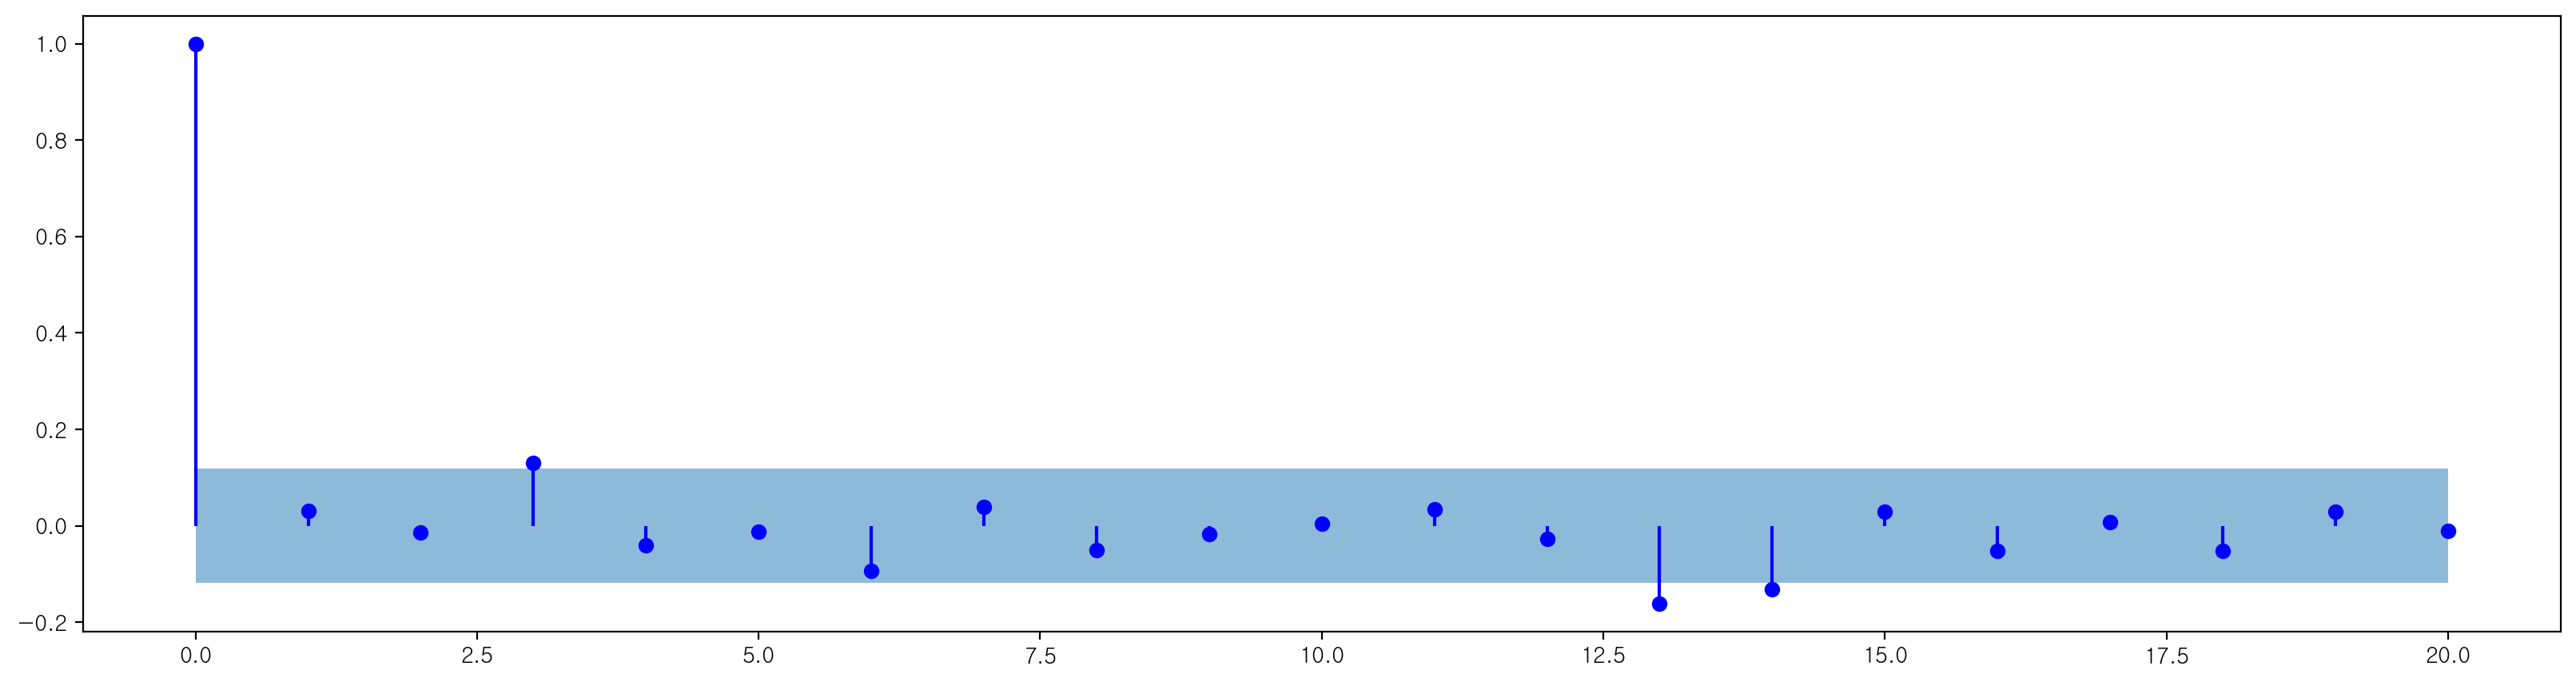

In [27]:
nlags = 20
pacfs = [pacf(log_diff["close"],k) for k in range(nlags+1)]
x = range(nlags+1)
fig = plt.figure(figsize=(20,5))
fig.set_facecolor('white')
 
## correlogram
markers, stemlines, baseline = plt.stem(x, pacfs, use_line_collection=True)
markers.set_color('blue')
stemlines.set_linestyle('-')
stemlines.set_color('blue')
baseline.set_visible(False) ## base line 안보이게
 
n = len(log_diff["close"])
upper_limit = 1.96/np.sqrt(n)
lower_limit = -1.96/np.sqrt(n)
plt.fill_between(x, lower_limit, upper_limit, alpha=0.5)
plt.show()

#### Conduct Engle's ARCH Test

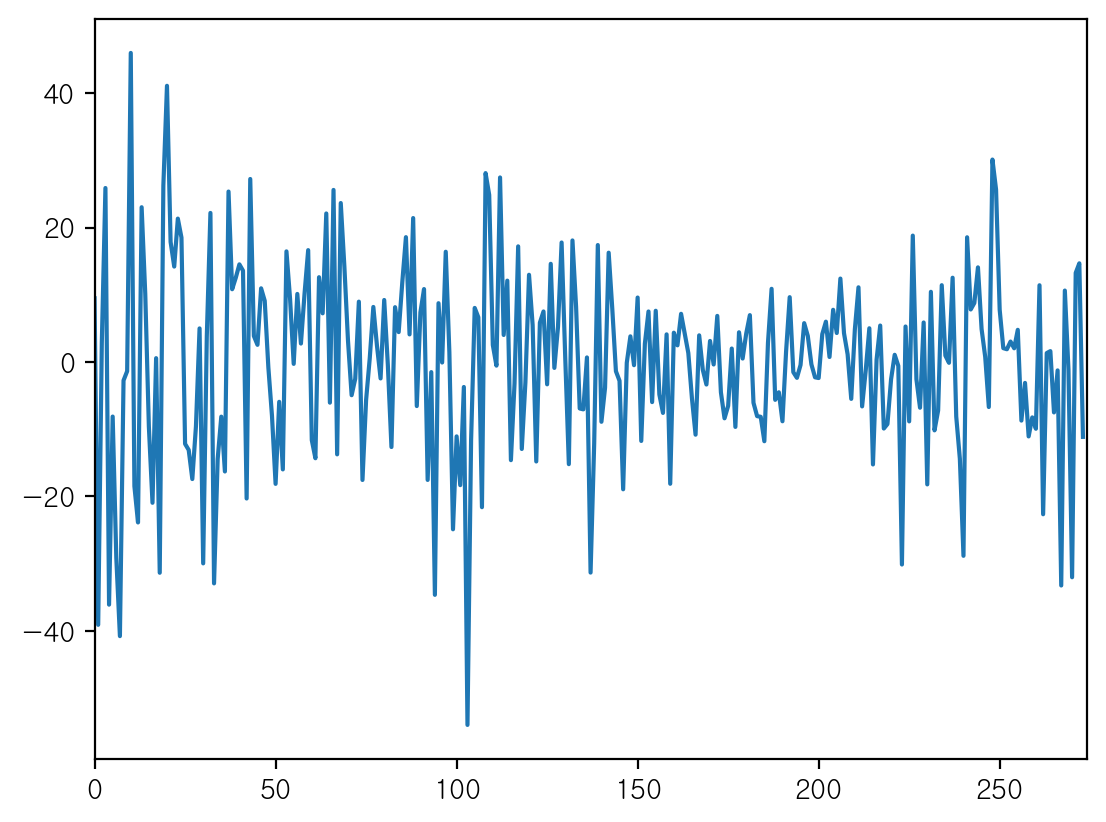

In [157]:
T = len(scale_df_MMax)
e = (scale_df_MMax - np.mean(scale_df_MMax))*100
plt.plot(e)
plt.xlim([0,T])
plt.show()

In [158]:
het_arch(e, nlags = 1,store = 'bool')

(1.3582923282034973,
 0.24383365536699467,
 1.3550835919051416,
 0.24541516353421539,
 <__main__.ResultsStore at 0x26f977ad190>)


### Modeling

In [171]:
mo_df = pd.DataFrame(scale_df_MMax)
data = mo_df.values

In [172]:
final_model = ARIMA(data ,order = (1,0,1)).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  274
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 150.571
Date:                Mon, 26 Dec 2022   AIC                           -293.142
Time:                        15:10:18   BIC                           -278.689
Sample:                             0   HQIC                          -287.341
                                - 274                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5400      0.009     60.169      0.000       0.522       0.558
ar.L1         -0.8334      0.108     -7.738      0.000      -1.044      -0.622
ma.L1          0.9047      0.091      9.894      0.000       0.725       1.084
sigma2         0.0195      0.001     14.323      0.000       0.017       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                19.74
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

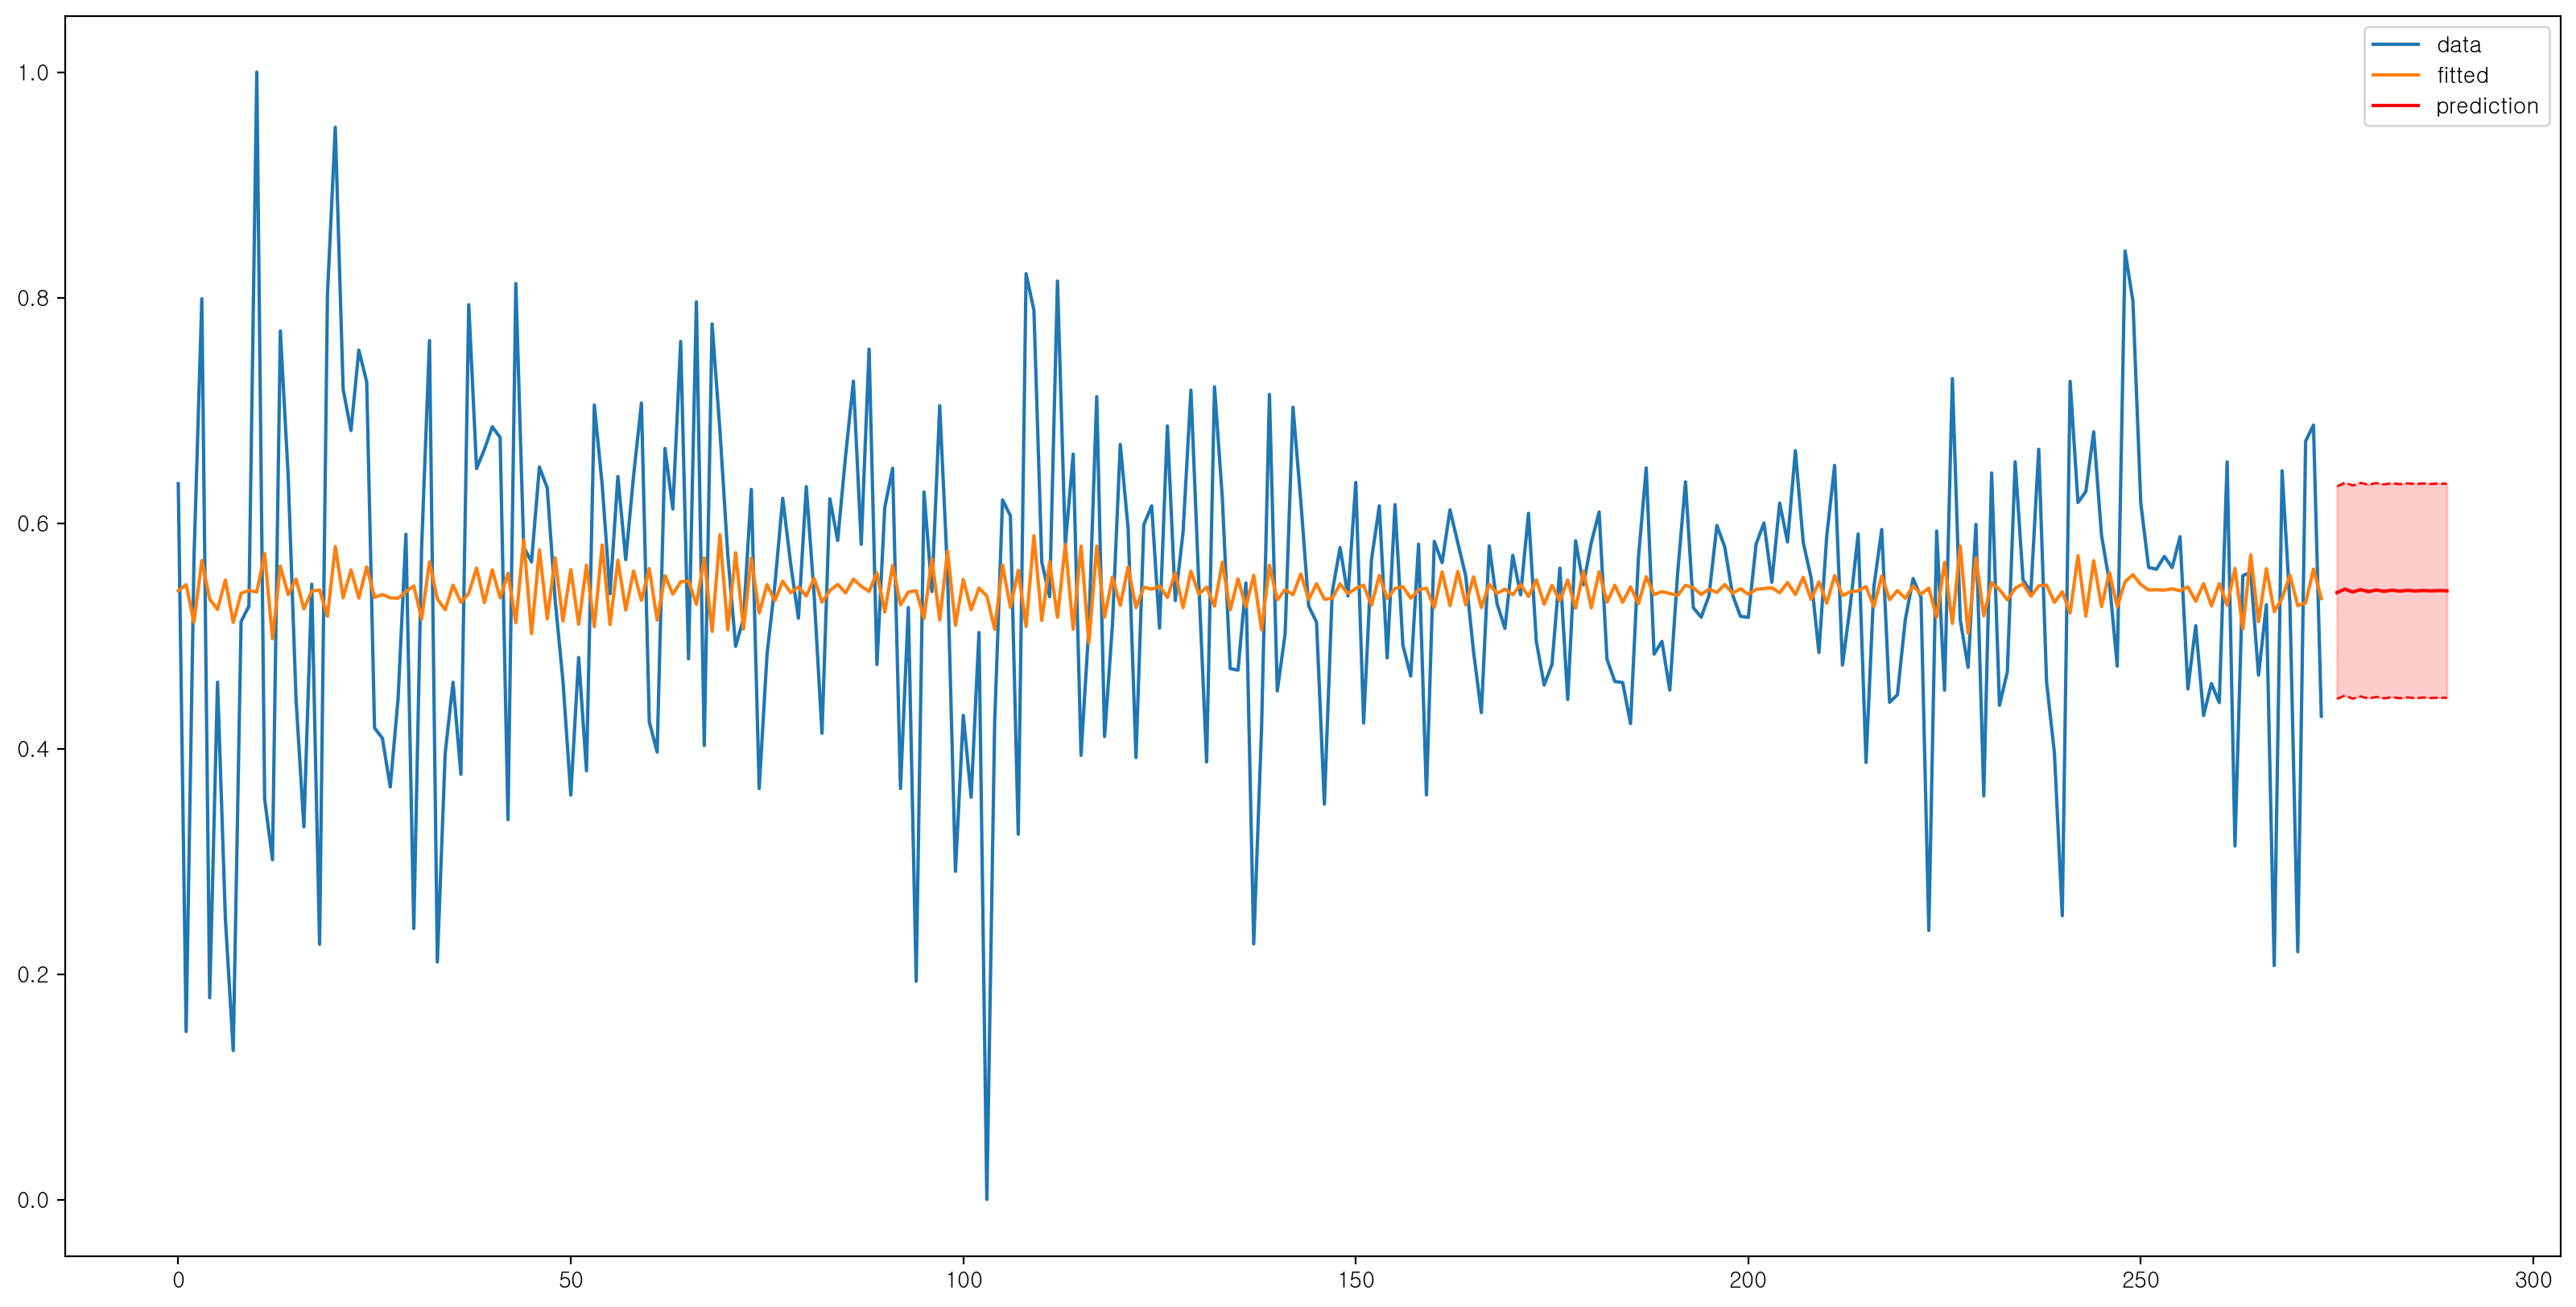

In [173]:
fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white')
fitted_values = final_model.fittedvalues ## in-sample prediction
## prediction
k = 15
forecast = final_model.get_forecast(k) ## out-of-sample prediction
predicted_values = forecast.predicted_mean
prediction_intervals = forecast.conf_int(alpha=0.5)
upper_limit = [x[1] for x in prediction_intervals]
lower_limit = [x[0] for x in prediction_intervals]
 
pred_x = range(len(data)+1, len(data)+k+1)
 
plt.plot(range(len(data)), data, label = 'data')
plt.plot(range(len(data)), fitted_values, label='fitted')
plt.plot(pred_x,predicted_values,color='red',label='prediction')
plt.plot(pred_x,lower_limit,color='red',linestyle='--',linewidth=1)
plt.plot(pred_x,upper_limit,color='red',linestyle='--',linewidth=1)
plt.fill_between(pred_x,lower_limit,upper_limit,color='red',alpha=0.2)
plt.legend()
plt.show()

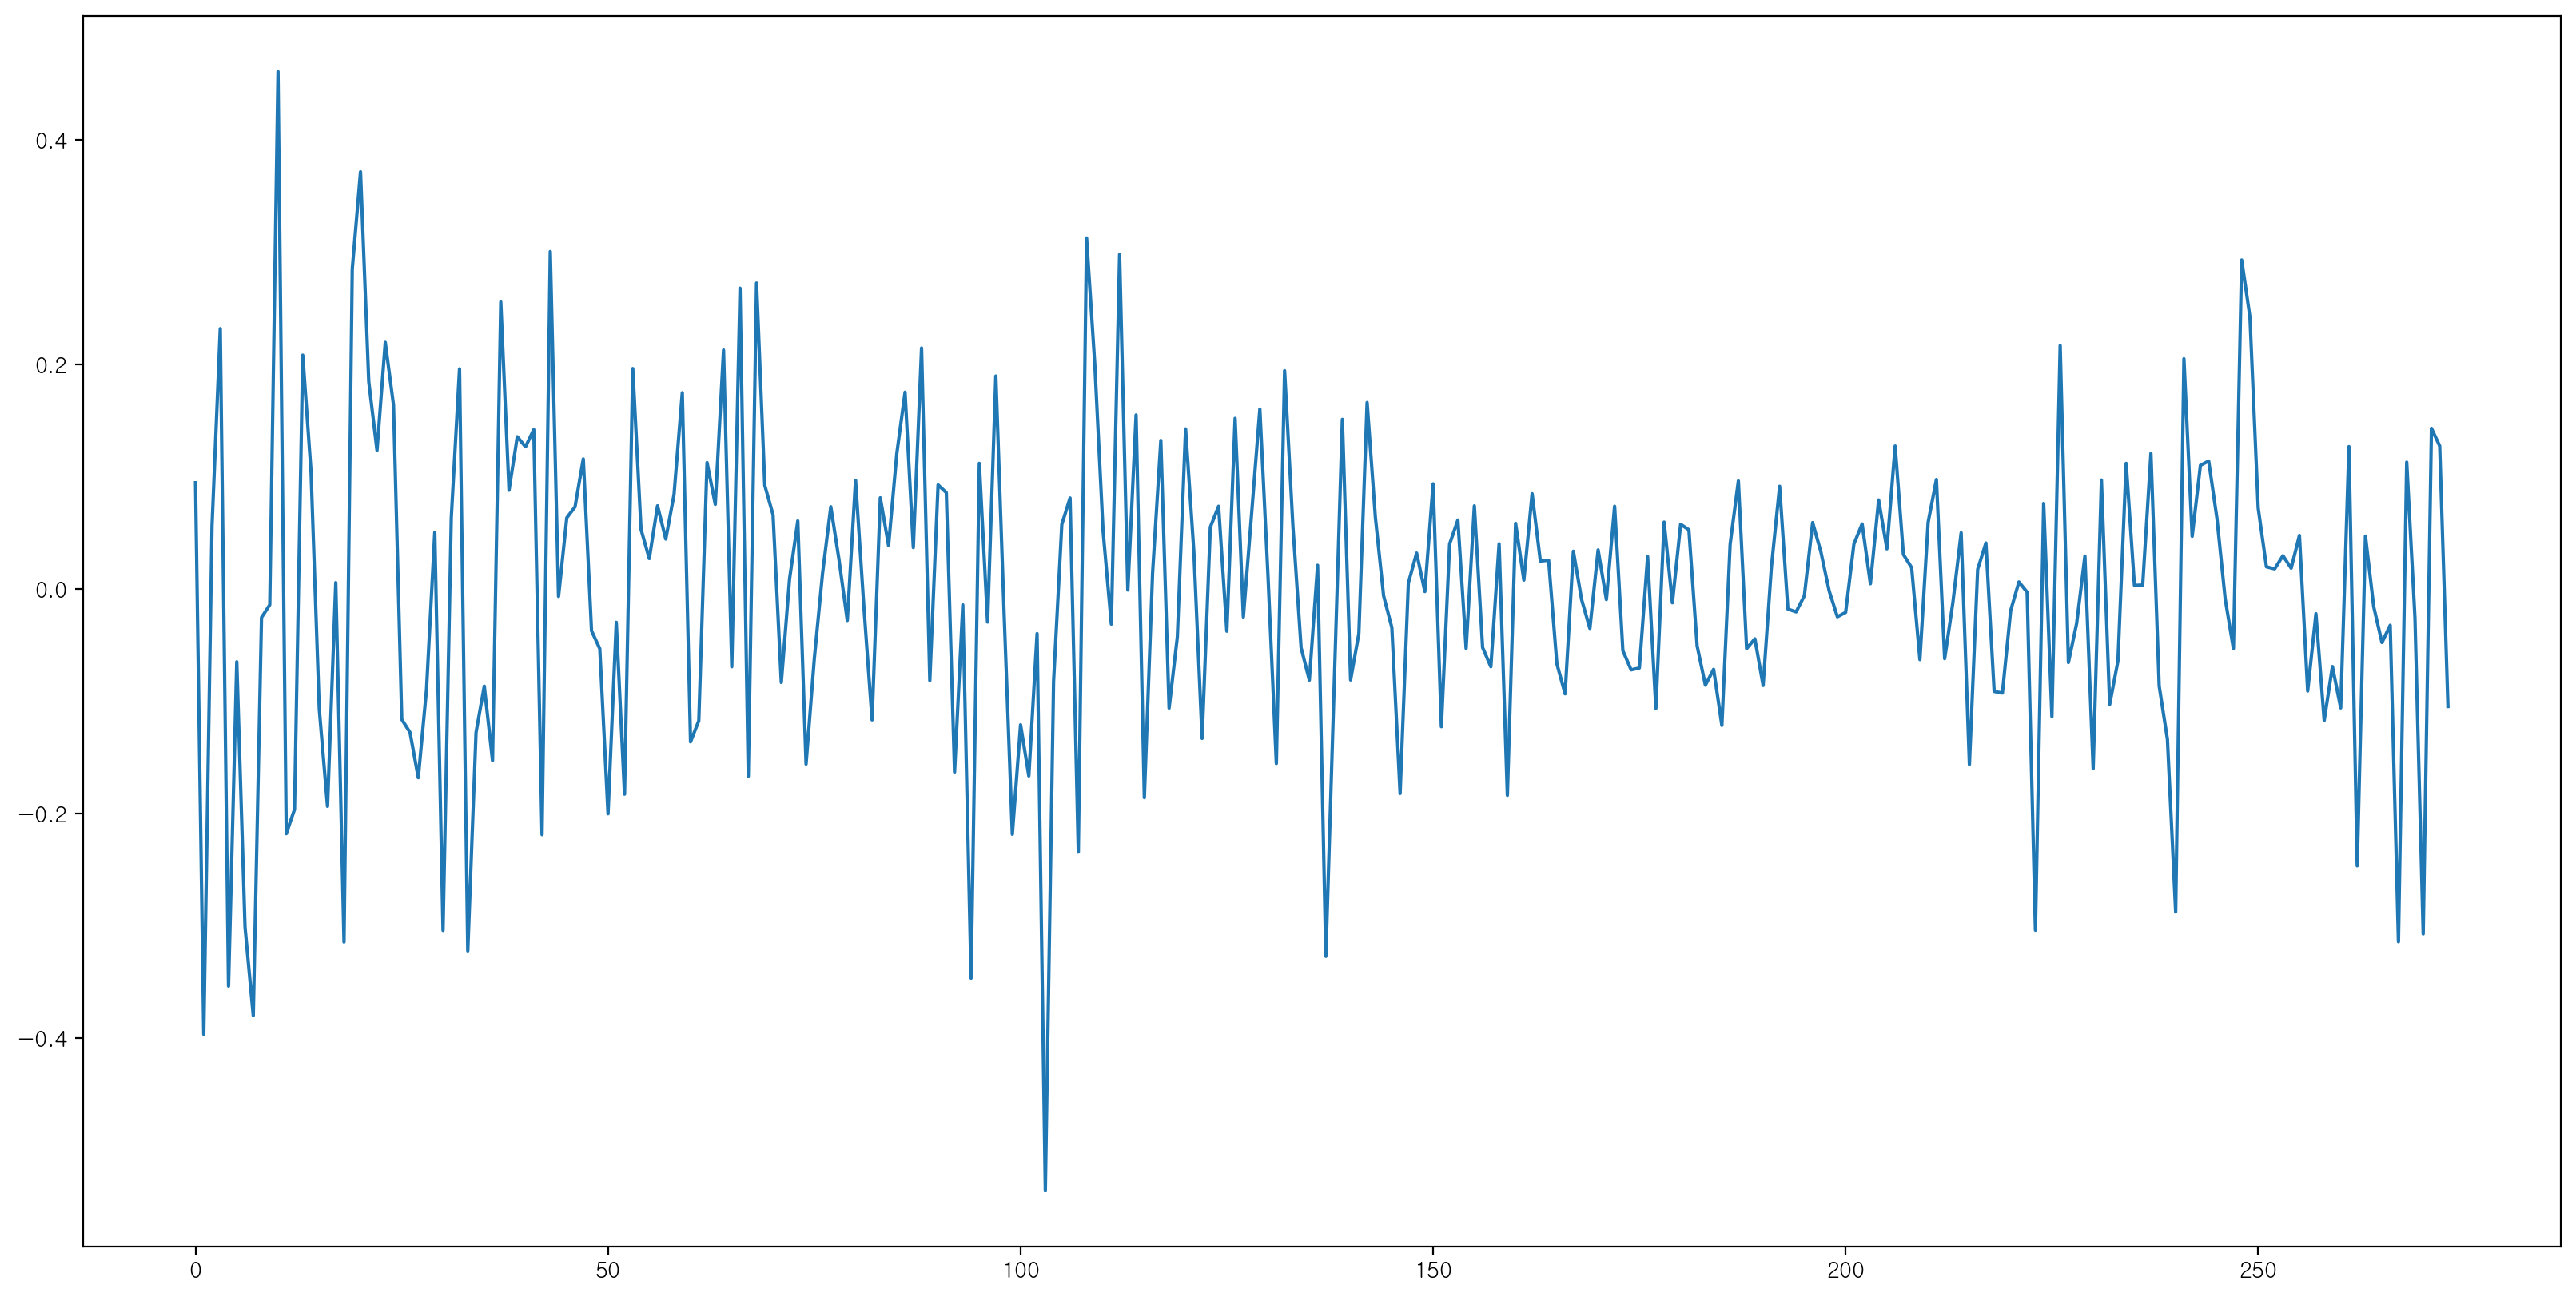

In [177]:
fig = plt.figure(figsize=(20,10))
plt.plot(mo_df.values - fitted_values.reshape(-1,1))

In [178]:
data  =  pd.DataFrame(mo_df.values - fitted_values.reshape(-1,1)).values
garch = arch.arch_model(data, vol='EGARCH', p=1, q=1)
res = garch.fit(update_freq=50)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -174.42630861798722
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


In [187]:
data  =  pd.DataFrame(mo_df).values
garch = arch.arch_model(data, vol='EGARCH', p=1, q=1)
res = garch.fit(update_freq=50)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -173.0455592979271
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 8


In [188]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                173.046
Distribution:                  Normal   AIC:                          -338.091
Method:            Maximum Likelihood   BIC:                          -323.639
                                        No. Observations:                  274
Date:                Mon, Dec 26 2022   Df Residuals:                      273
Time:                        15:11:49   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5386  6.391e-03     84.272      0.000 [  0.526,  0.551]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         -0.1236  5.536e-02     -2.233  2.556e-02 [ -0.232,-1.511e-02]
alpha[1]       0.1706  5.852e-02      2.916  3.550e-03  [5.593e-02,  0.285]
beta[1]        0.9701  1.389e-02     69.851      0.000    [  0.943,  0.997]
===========================================================================

Covariance estimator: robust
"""

In [217]:
date = pd.DataFrame(df.iloc[1:,0]).reset_index(drop=True)
vol = pd.concat([date, pd.DataFrame(res.conditional_volatility)], axis = 1)
vol.columns = ["date", "volatility"]

Text(0.5, 1.0, 'KOSPI 200 Interest Rate Volatility')

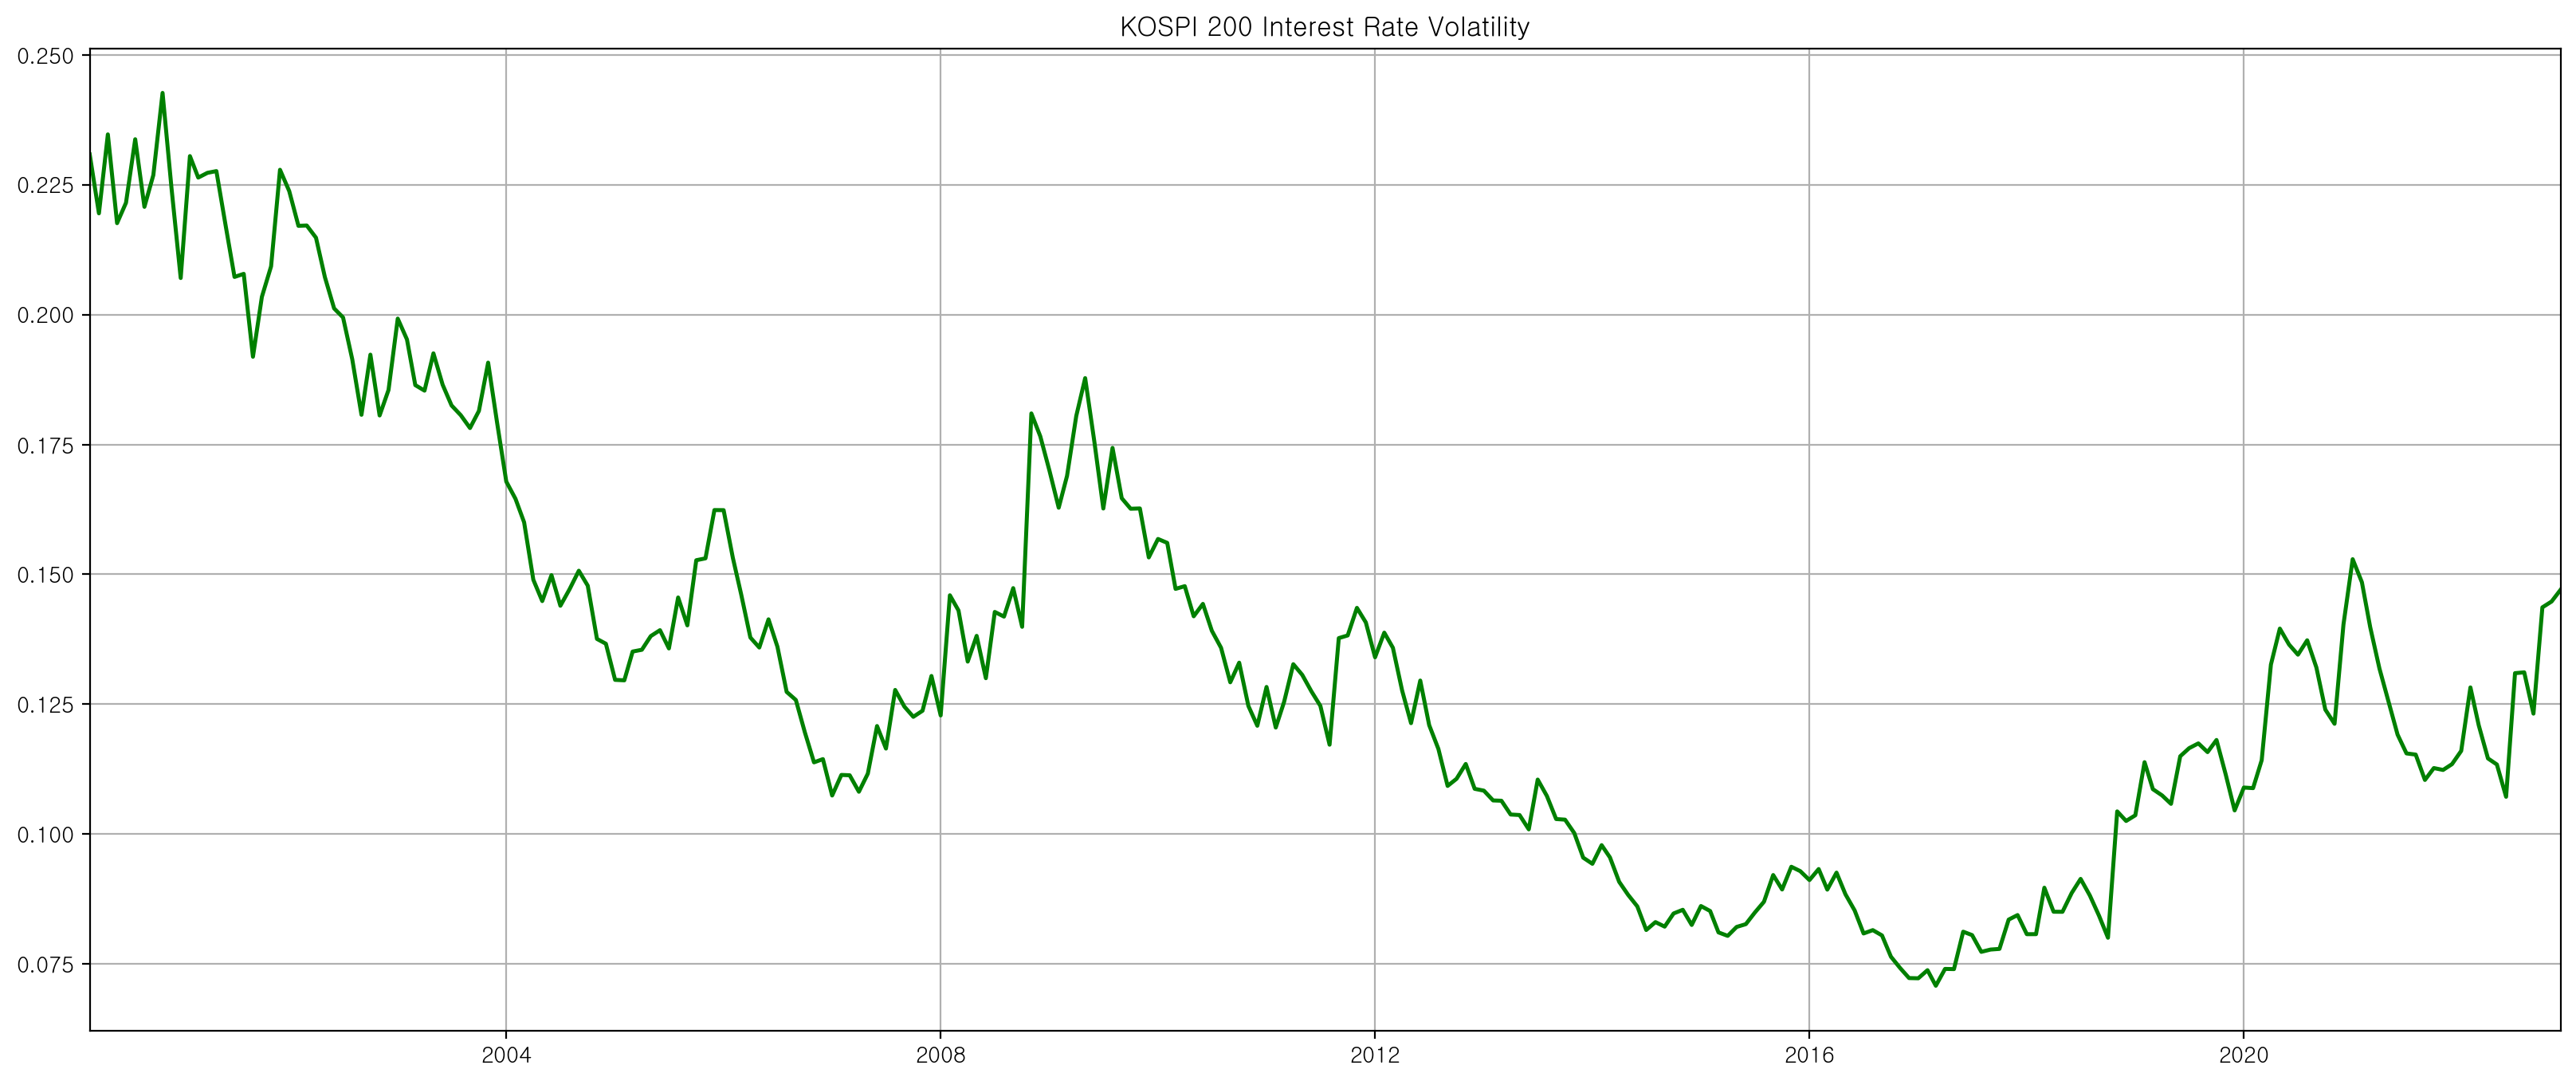

In [240]:
fig = plt.figure(figsize=(20,8))
plt.plot(vol["date"], vol["volatility"], 'g-', linewidth = 1.8)
plt.xlim([min(vol["date"]),max(vol["date"])])
plt.grid(True)
plt.title('KOSPI 200 Interest Rate Volatility')